### Contents:

- Covid-19 global data analysis.
- Comparing trajectories of deaths, confirmed and active cases for different countries.
- Time Series forecasting: Using ARIMA model to predict deaths in US and India for next 15 days.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv
import itertools
from collections import defaultdict
import datetime as dt
import re
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 50)
plt.rcParams["figure.figsize"] = [10, 10]
sns.set_style('darkgrid')

In [3]:
base_dir = '../data/Global/csse_covid_19_daily_reports/'

In [4]:
abs_path = os.path.abspath(base_dir)

In [5]:
files = os.listdir(abs_path)
csv_files = filter(lambda file: '.csv' in file, files)
csv_abs_path = [os.path.join(abs_path, csv_file) for csv_file in csv_files]

In [6]:
csv_abs_path = sorted(csv_abs_path)

In [7]:
covid_list_6_columns = []
covid_list_8_columns = []
covid_list_12_columns = []
covid_list_14_columns = []
d = defaultdict()
for file in csv_abs_path:
    with open(file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) 
        l = [i for i in reader]
        size = len(l[0])
        d[size] = size + 1
    if size == 6:
        covid_list_6_columns.extend(l)
    elif size == 8:
        covid_list_8_columns.extend(l)
    elif size == 12:
        covid_list_12_columns.extend(l)
    elif size == 14:
        covid_list_14_columns.extend(l)

### Columns:

- df6: Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
- df8: Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
- df12: 'FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','Active','Combined_Key'
- df14: 'FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','Active','Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio'


### Create DataFrame

In [8]:
df6 = pd.DataFrame(covid_list_6_columns, columns=['Province/State','Country/Region','Last Update','Confirmed','Deaths','Recovered'])
df8 = pd.DataFrame(covid_list_8_columns, columns=['Province/State','Country/Region','Last Update','Confirmed','Deaths','Recovered','Latitude','Longitude'])
df12 = pd.DataFrame(covid_list_12_columns, columns=['FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','Active','Combined_Key'])
df14 = pd.DataFrame(covid_list_14_columns, columns=['FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','Active','Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio'])

In [9]:
df6.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,Anhui,Mainland China,1/22/2020 17:00,1,,
1,Beijing,Mainland China,1/22/2020 17:00,14,,
2,Chongqing,Mainland China,1/22/2020 17:00,6,,
3,Fujian,Mainland China,1/22/2020 17:00,1,,
4,Gansu,Mainland China,1/22/2020 17:00,,,


In [10]:
df8.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,Mainland China,2020-03-01T10:13:19,66907,2761,31536,30.9756,112.2707
1,,South Korea,2020-03-01T23:43:03,3736,17,30,36.0000,128.0000
2,,Italy,2020-03-01T23:23:02,1694,34,83,43.0000,12.0000
3,Guangdong,Mainland China,2020-03-01T14:13:18,1349,7,1016,23.3417,113.4244
4,Henan,Mainland China,2020-03-01T14:13:18,1272,22,1198,33.8820,113.6140


In [11]:
df12.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,36061,New York City,New York,US,3/22/20 23:45,40.7672726,-73.97152637,9654,63,0,0,"New York City, New York, US"
1,36059,Nassau,New York,US,3/22/20 23:45,40.74066522,-73.58941873,1900,4,0,0,"Nassau, New York, US"
2,36119,Westchester,New York,US,3/22/20 23:45,41.16278376,-73.75741653,1873,0,0,0,"Westchester, New York, US"
3,36103,Suffolk,New York,US,3/22/20 23:45,40.88320119,-72.8012172,1034,9,0,0,"Suffolk, New York, US"
4,36087,Rockland,New York,US,3/22/20 23:45,41.15027894,-74.02560498,455,1,0,0,"Rockland, New York, US"


In [12]:
df14.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,45001,Abbeville,South Carolina,US,2020-05-30 02:32:48,34.22333378,-82.46170658,39,0,0,39,"Abbeville, South Carolina, US",159.0084396787214,0.0
1,22001,Acadia,Louisiana,US,2020-05-30 02:32:48,30.2950649,-92.41419698,401,23,0,378,"Acadia, Louisiana, US",646.305101136272,5.7356608478802995
2,51001,Accomack,Virginia,US,2020-05-30 02:32:48,37.76707161,-75.63234615,827,12,0,815,"Accomack, Virginia, US",2559.1038494863224,1.4510278113663846
3,16001,Ada,Idaho,US,2020-05-30 02:32:48,43.4526575,-116.24155159999998,803,22,0,781,"Ada, Idaho, US",166.7403812810562,2.73972602739726
4,19001,Adair,Iowa,US,2020-05-30 02:32:48,41.33075609,-94.47105874,9,0,0,9,"Adair, Iowa, US",125.83892617449665,0.0


In [13]:
df6['Last Update'].dtype

dtype('O')

In [14]:
len(df6)

2818

In [15]:
len(df12)

214844

In [16]:
len(df12) + len(df8) + len(df6)

222461

### Merge 3 DataFrames

In [17]:
df1 = pd.concat([df6, df8, df12, df14], axis=0, sort=False)

In [18]:
df1.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,Anhui,Mainland China,1/22/2020 17:00,1,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Beijing,Mainland China,1/22/2020 17:00,14,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Chongqing,Mainland China,1/22/2020 17:00,6,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fujian,Mainland China,1/22/2020 17:00,1,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gansu,Mainland China,1/22/2020 17:00,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

In [19]:
df1['Country/Region'] = df1['Country/Region'].fillna('')
df1['Country_Region'] = df1['Country_Region'].fillna('')
df1['Country_Region'] = df1['Country_Region'] + df1['Country/Region']

In [20]:
df1 = df1.drop(columns='Country/Region')

In [21]:
df1['Last Update'] = df1['Last Update'].fillna('')
df1['Last_Update'] = df1['Last_Update'].fillna('')
df1['Last_Update'] = df1['Last_Update'] + df1['Last Update']
df1 = df1.drop(columns=['Last Update'])

In [22]:
df1['Province/State'] = df1['Province/State'].fillna('')
df1['Province_State'] = df1['Province_State'].fillna('')
df1['Province_State'] = df1['Province_State'] + df1['Province/State']
df1 = df1.drop(columns=['Province/State'])

#### Uniform Datetime format

- DataFrame has 4-5 different datetime formats.
- When pd.to_datetime is used, majority of the dates become NAT, because it is not able to infer them.
- The problem is solved using dateutil package.

In [23]:
import dateutil.parser
date = dateutil.parser.parse("1/23/20 17:00").strftime("%m/%d/%Y, %H:%M:%S")
date

'01/23/2020, 17:00:00'

In [24]:
df1['Last_Update'] = df1['Last_Update'].apply(lambda x: dateutil.parser.parse(x).strftime("%Y-%m-%d %H:%M:%S"))

In [25]:
df1['Last_Update'] = pd.to_datetime(df1['Last_Update'], infer_datetime_format=True, errors='coerce')

In [26]:
df1.isna().sum()

Confirmed                   0
Deaths                      0
Recovered                   0
Latitude               332479
Longitude              332479
FIPS                     7617
Admin2                   7617
Province_State              0
Country_Region              0
Last_Update                 0
Lat                      7617
Long_                    7617
Active                   7617
Combined_Key             7617
Incidence_Rate         222461
Case-Fatality_Ratio    222461
dtype: int64

#### Only 4799 rows have latitude and longitude values out of 201896 rows, that is 2%, thus removing those columns. 

In [27]:
df1 = df1.drop(columns=['Latitude', 'Longitude'])

In [28]:
df1.isna().sum()

Confirmed                   0
Deaths                      0
Recovered                   0
FIPS                     7617
Admin2                   7617
Province_State              0
Country_Region              0
Last_Update                 0
Lat                      7617
Long_                    7617
Active                   7617
Combined_Key             7617
Incidence_Rate         222461
Case-Fatality_Ratio    222461
dtype: int64

In [29]:
df1['date'] = pd.to_datetime(df1['Last_Update']).dt.date

In [30]:
df1.loc[df1['Country_Region'].isin(['Mainland China', 'China']), 'Country_Region'] = 'China'

In [31]:
df1.Deaths.unique()

array(['', '17', '1', ..., '1551', '2456', '5097'], dtype=object)

### Check and update datatypes if not correct

In [32]:
df1.loc[df1['Deaths'] == '', 'Deaths'] = 0

In [33]:
df1.loc[df1['Recovered'] == '', 'Recovered'] = 0

In [34]:
df1.loc[df1['Confirmed'] == '', 'Confirmed'] = 0

In [35]:
df1['Active'] = df1['Active'].fillna(0)

In [36]:
df1.dtypes

Confirmed                      object
Deaths                         object
Recovered                      object
FIPS                           object
Admin2                         object
Province_State                 object
Country_Region                 object
Last_Update            datetime64[ns]
Lat                            object
Long_                          object
Active                         object
Combined_Key                   object
Incidence_Rate                 object
Case-Fatality_Ratio            object
date                           object
dtype: object

In [37]:
df1[['Confirmed', 'Deaths', 'Recovered', 'Active']] = df1[['Confirmed', 'Deaths', 'Recovered', 'Active']].astype(np.int)

In [38]:
df1['Active_Cases'] = df1['Confirmed'] - df1['Deaths'] - df1['Recovered']

#### New Feature

In [39]:
df1[(~df1['Active'].isna()) & ( df1['Active'] != 0 )]

,Confirmed,Deaths,Recovered,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,date,Active_Cases
3189,669,6,4,,,New South Wales,Australia,2020-03-22 23:48:00,-33.8688,151.2093,659,"New South Wales, Australia",NaN,NaN,2020-03-22,659
3190,296,0,70,,,Victoria,Australia,2020-03-22 23:48:00,-37.8136,144.9631,226,"Victoria, Australia",NaN,NaN,2020-03-22,226
3191,259,0,8,,,Queensland,Australia,2020-03-22 23:48:00,-27.4698,153.0251,251,"Queensland, Australia",NaN,NaN,2020-03-22,251
3192,120,1,1,,,Western Australia,Australia,2020-03-22 23:48:00,-31.9505,115.8605,118,"Western Australia, Australia",NaN,NaN,2020-03-22,118
3193,100,0,6,,,South Australia,Australia,2020-03-22 23:48:00,-34.9285,138.6007,94,"South Australia, Australia",NaN,NaN,2020-03-22,94
3194,22,0,3,,,Tasmania,Australia,2020-03-22 23:48:00,-42.8821,147.3272,19,"Tasmania, Australia",NaN,NaN,2020-03-22,19
3195,19,0,0,,,Australian Capital Territory,Australia,2020-03-22 23:48:00,-35.4735,149.0124,19,"Australian Capital Territory, Australia",NaN,NaN,2020-03-22,19
3196,5,0,0,,,Northern Territory,Australia,2020-03-22 23:48:00,-12.4634,130.8456,5,"Northern Territory, Australia",NaN,NaN,2020-03-22,5
3199,20,0,10,,,Macau,China,2020-03-22 14:23:00,22.1667,113.55,10,"Macau, China",NaN,NaN,2020-03-22,10
3200,136,2,114,,,Gansu,China,2020-03-22 14:23:00,37.8099,101.0583,20,"Gansu, China",NaN,NaN,2020-03-22,20


In [40]:
df1.date = pd.to_datetime(df1['date'])

In [41]:
df1.dtypes

Confirmed                       int64
Deaths                          int64
Recovered                       int64
FIPS                           object
Admin2                         object
Province_State                 object
Country_Region                 object
Last_Update            datetime64[ns]
Lat                            object
Long_                          object
Active                          int64
Combined_Key                   object
Incidence_Rate                 object
Case-Fatality_Ratio            object
date                   datetime64[ns]
Active_Cases                    int64
dtype: object

In [42]:
df_china = df1.loc[(df1['Country_Region'] == 'China') & (df1['Confirmed'] != 0)]

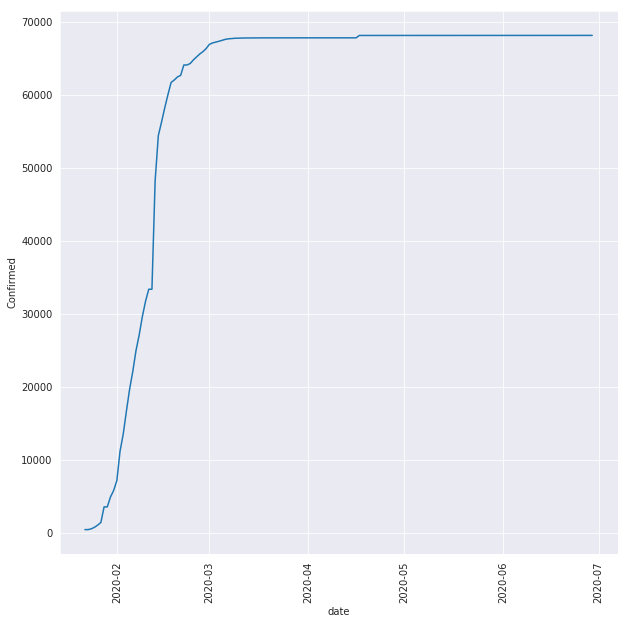

In [43]:
sns.lineplot(x='date', y='Confirmed', data=df_china.loc[df_china.Province_State == 'Hubei'])
plt.xticks(rotation=90)
plt.show()

#### Notice the sharp increase in number of deaths, when the curve had already flattened.

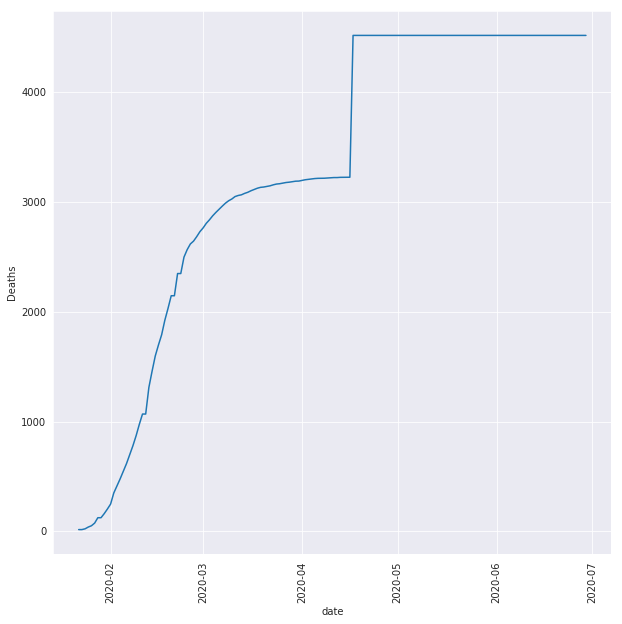

In [44]:
sns.lineplot(x='date', y='Deaths', data=df_china.loc[df_china.Province_State == 'Hubei'])
plt.xticks(rotation=90)
plt.show()

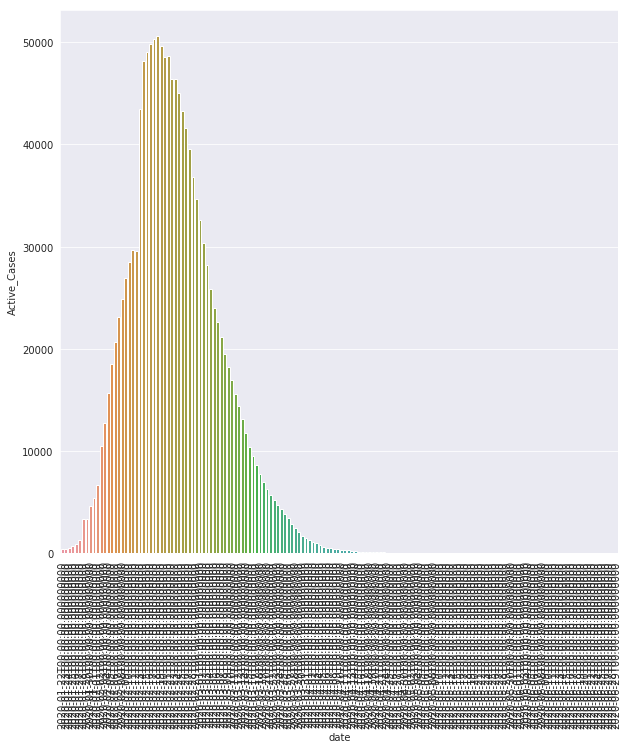

In [45]:
sns.barplot(x='date', y='Active_Cases', data=df_china.loc[df_china.Province_State == 'Hubei'])
plt.xticks(rotation=90)
plt.show()

In [46]:
df_china.groupby(['Province_State'])['Deaths'].max().sort_values(ascending=False)

Province_State
Hubei             4512
Henan               22
Heilongjiang        13
Beijing              9
Guangdong            8
Hong Kong            7
Shanghai             7
Shandong             7
Hainan               6
Anhui                6
Chongqing            6
Hebei                6
Hunan                4
Shaanxi              3
Sichuan              3
Tianjin              3
Xinjiang             3
Gansu                2
Liaoning             2
Jilin                2
Guangxi              2
Yunnan               2
Guizhou              2
Fujian               1
Zhejiang             1
Inner Mongolia       1
Jiangxi              1
Macau                0
Ningxia              0
Qinghai              0
Shanxi               0
Tibet                0
Jiangsu              0
Name: Deaths, dtype: int64

In [47]:
yesterday = (dt.datetime.now().date() - dt.timedelta(days=1)).strftime('%Y-%m-%d')

In [48]:
yesterday

'2020-06-28'

In [49]:
df1[df1.date == yesterday].groupby(['Country_Region']).sum().sort_values(by='Deaths', ascending=False).head(10)

,Confirmed,Deaths,Recovered,Active,Active_Cases
Country_Region,,,,,
US,2510151,125539,679308,1627152,1705304
Brazil,1313667,57070,727715,528882,528882
United Kingdom,311727,43598,1364,266765,266765
Italy,240136,34716,188584,16836,16836
France,199473,29781,75773,93919,93919
Spain,248469,28341,150376,69752,69752
Mexico,212802,26381,160721,25700,25700
India,528859,16095,309713,203051,203051
Iran,220180,10364,180661,29155,29155


In [50]:
df2 = df1.loc[df1.date == yesterday].groupby(['Province_State']).max()#.sort_values(by=['Deaths', 'Confirmed', 'Active', 'Recovered'], ascending=['False', 'False', 'False', 'False'])

### Analysis

- Top 10 countries with maximum fatalities
- Top 10 Provincies in US with maximum fatalities
- Countries with highest fatalities to recovery ratio
- Countries with maximum recovery rate
- Country with most active cases
- Country with largest single day spike in: 
    - Deaths
    - Confirmed
    - Recovered

#### Top Provinces / States with Maximum Fatalities

In [51]:
provincies_with_maximum_fatalities = df2.sort_values(by='Deaths', ascending=False)
top_10_provinces_with_maximum_fatalities = provincies_with_maximum_fatalities.head(10)

In [52]:
top_10_provinces_with_maximum_fatalities

,Confirmed,Deaths,Recovered,FIPS,Admin2,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,date,Active_Cases
Province_State,,,,,,,,,,,,,,,
England,160150,38982,0,,,United Kingdom,2020-06-28 04:34:04,52.3555,-1.1743,121168,"England, United Kingdom",286.09862586910384,24.34093037777084,2020-06-28,121168
,220180,29704,180661,,,Zimbabwe,2020-06-28 04:34:04,9.9456,95.956,91271,Zimbabwe,91.52375696510191,8.554913294797688,2020-06-28,91271
New York,214434,22441,0,90036,Yates,US,2020-06-28 04:34:04,44.74530905,-79.36691763,191993,"Yates, New York, US",998.4626041121116,9.63855421686747,2020-06-28,191993
Lombardia,93664,16626,66046,,,Italy,2020-06-28 04:34:04,45.46679409,9.190347404,10992,"Lombardia, Italy",931.0005572246673,17.750683293474548,2020-06-28,10992
Sao Paulo,265581,14263,49295,,,Brazil,2020-06-28 04:34:04,-23.5505,-46.6333,202023,"Sao Paulo, Brazil",578.3678141940613,5.370489605807644,2020-06-28,202023
Rio de Janeiro,108803,9789,88784,,,Brazil,2020-06-28 04:34:04,-22.9068,-43.1729,10230,"Rio de Janeiro, Brazil",630.1961147511463,8.996994568164482,2020-06-28,10230
Madrid,71839,8420,40736,,,Spain,2020-06-28 04:34:04,40.4168,-3.7038,22683,"Madrid, Spain",1081.6440314747135,11.720653127131502,2020-06-28,22683
Maharashtra,159133,7273,84245,,,India,2020-06-28 04:34:04,19.449759,76.108221,67615,"Maharashtra, India",129.2249007897025,4.570390805175545,2020-06-28,67615
Ciudad de Mexico,46610,6324,36422,,,Mexico,2020-06-28 04:34:04,19.4326,-99.1332,3864,"Ciudad de Mexico, Mexico",516.8182138225865,13.567903883286847,2020-06-28,3864


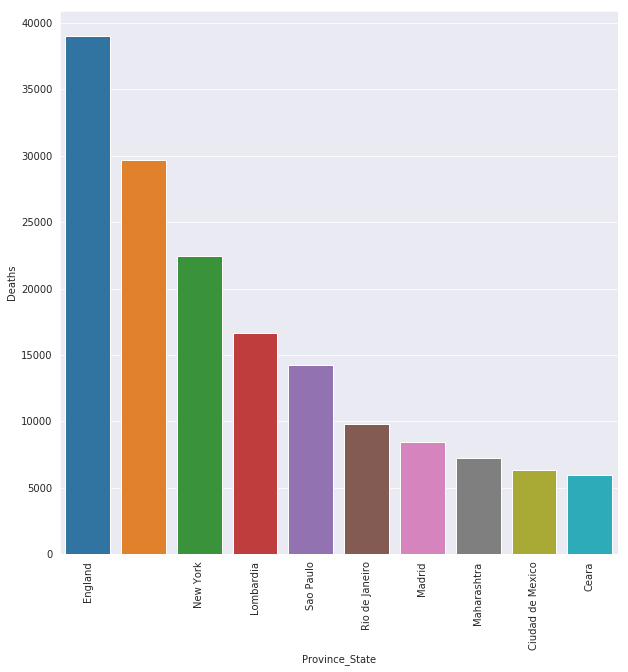

In [53]:
sns.barplot(data = top_10_provinces_with_maximum_fatalities, 
            x=top_10_provinces_with_maximum_fatalities.index, 
            y='Deaths')
plt.xticks(rotation=90)
plt.show()

#### Top 10 countries with maximum fatalities

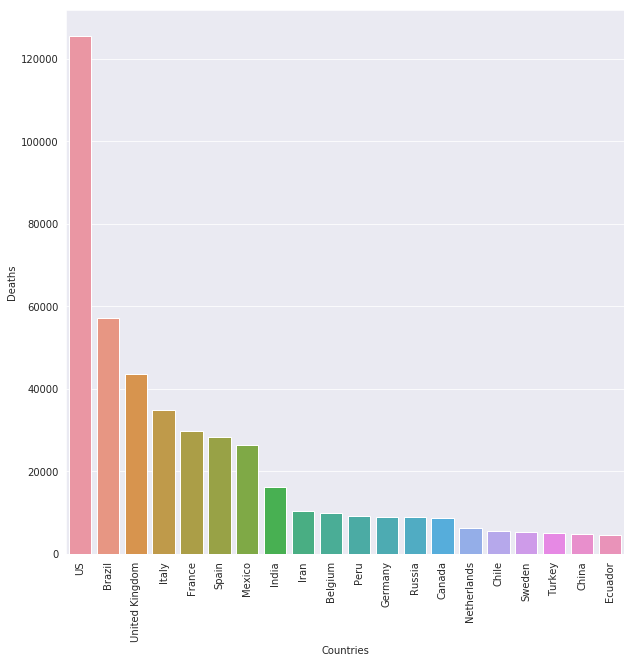

In [54]:
top_20_countries_most_deaths = df1[df1.date == yesterday].groupby(['Country_Region']).sum().sort_values(by='Deaths', ascending=False).head(20)
sns.barplot(data = top_20_countries_most_deaths, x=top_20_countries_most_deaths.index, y='Deaths')
plt.xticks(rotation=90)
plt.xlabel('Countries')
plt.show()

#### Top 10 Countries with most active cases

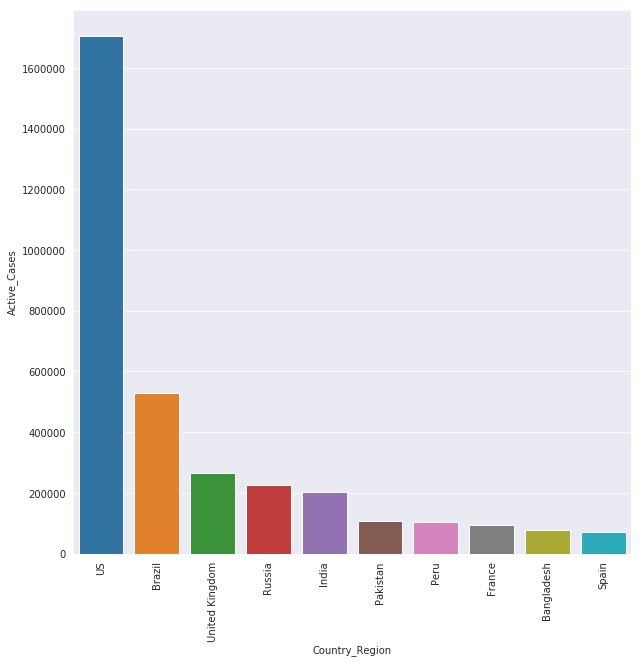

In [55]:
df3 = df1.loc[df1.date == yesterday].groupby(['Country_Region'])['Active_Cases'].sum()#.iloc[1:, :].head(10)
top_20_countries_most_active_cases = df3.sort_values(ascending=False)[:10]
sns.barplot(x=top_20_countries_most_active_cases.index, y=top_20_countries_most_active_cases)
plt.xticks(rotation=90)
plt.show()

#### Countries with most recoveries

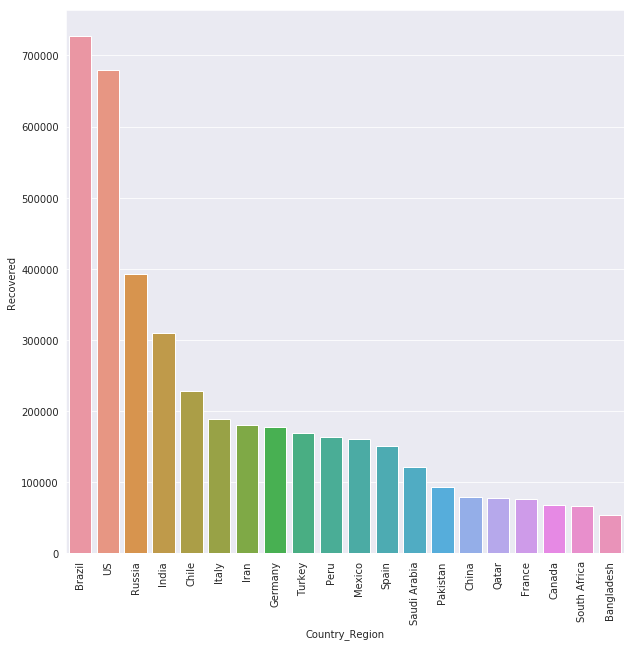

In [56]:
df3 = df1.loc[df1.date == yesterday].groupby(['Country_Region'])['Recovered'].sum()
top_20_countries_most_recovered_cases = df3.sort_values(ascending=False)[:20]
sns.barplot(x=top_20_countries_most_recovered_cases.index, y=top_20_countries_most_recovered_cases)
plt.xticks(rotation=90)
plt.show()

#### Top 10 Countries with Highest Death to Recovery Ratios

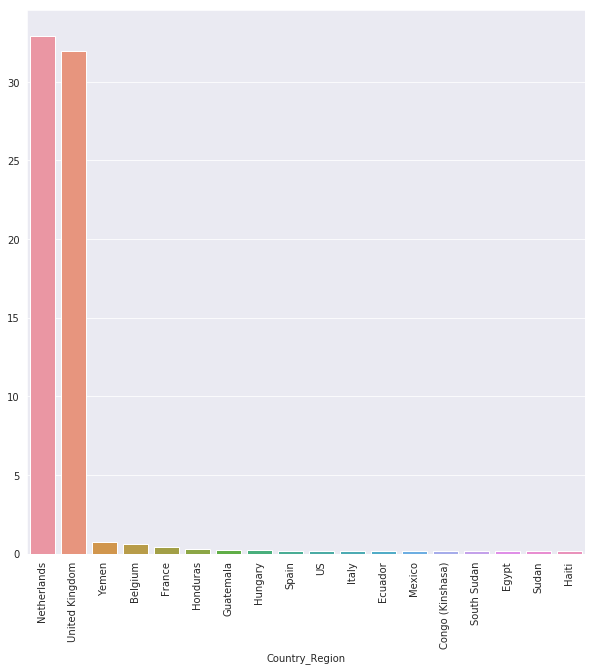

In [57]:
df3 = df1.loc[df1.date == yesterday].groupby('Country_Region').sum()
df3['Death_Recovery_Ratio'] = df3['Deaths'] / df3['Recovered']
top_20_highest_death_recovery_ratio = df3.sort_values('Death_Recovery_Ratio', ascending=False).head(20)
top_20_highest_death_recovery_ratio = top_20_highest_death_recovery_ratio[top_20_highest_death_recovery_ratio['Death_Recovery_Ratio'] != np.inf]
sns.barplot(x=top_20_highest_death_recovery_ratio.index, y=top_20_highest_death_recovery_ratio['Death_Recovery_Ratio'].values)
plt.xticks(rotation=90)
plt.show()

#### Note:

- Netherlands and UK have highest death to recovery rate i.e 1 person recovers when ~33 people die.

#### Comparing Top Countries Recovery Rates

In [58]:
countries = ['China', 'US', 'India', 'China', 'France', 'Italy', 'Iran', 'Belgium']

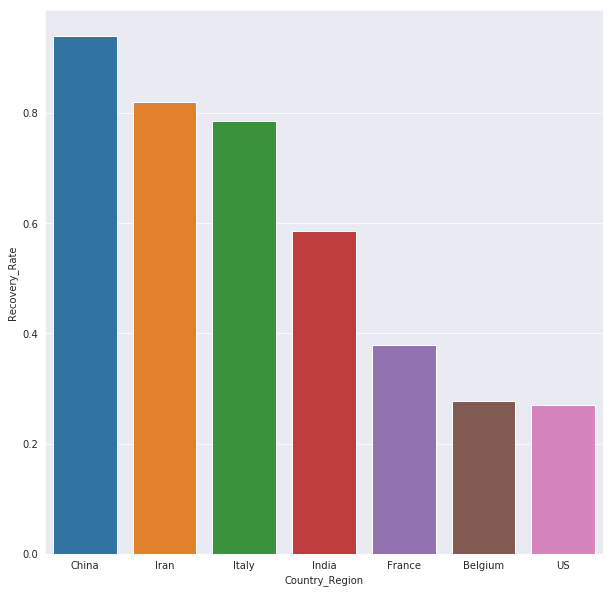

In [59]:
df_new = df1[df1.date == yesterday].groupby(['Country_Region']).sum()
df_new.loc[:, 'Recovery_Rate'] =  df_new['Recovered'] / df_new['Confirmed']
df_new = df_new.sort_values(by='Recovery_Rate', ascending=False)
df_recovery_rates = df_new.loc[countries].drop_duplicates().sort_values(by='Recovery_Rate', ascending=False)
sns.barplot(data=df_recovery_rates, x=df_recovery_rates.index, y='Recovery_Rate')
plt.show()

#### Top US Provinces with maximum impact

In [60]:
us_state_abbrev = """Alabama - AL

Alaska - AK

Arizona - AZ

Arkansas - AR

California - CA

Colorado - CO

Connecticut - CT

Delaware - DE

Florida - FL

Georgia - GA

Hawaii - HI

Idaho - ID

Illinois - IL

Indiana - IN

Iowa - IA

Kansas - KS

Kentucky - KY

Louisiana - LA

Maine - ME

Maryland - MD

Massachusetts - MA

Michigan - MI

Minnesota - MN

Mississippi - MS

Missouri - MO

Montana - MT

Nebraska - NE

Nevada - NV

New Hampshire - NH

New Jersey - NJ

New Mexico - NM

New York - NY

North Carolina - NC

North Dakota - ND

Ohio - OH

Oklahoma - OK

Oregon - OR

Pennsylvania - PA

Rhode Island - RI

South Carolina - SC

South Dakota - SD

Tennessee - TN

Texas - TX

Utah - UT

Vermont - VT

Virginia - VA

Washington - WA

West Virginia - WV

Wisconsin - WI

Wyoming - WY
"""

In [61]:
us_state_mapping = {}
pattern = re.compile(r'(\w+\s?\w+)\s+-\s+(\w+)', re.MULTILINE)
matches = pattern.finditer(us_state_abbrev) 
for match in matches:
    us_state_mapping[match.group(2)] = match.group(1)
    print(f"{match.group(2)} : {match.group(1)}")
us_state_mapping

AL : Alabama
AK : Alaska
AZ : Arizona
AR : Arkansas
CA : California
CO : Colorado
CT : Connecticut
DE : Delaware
FL : Florida
GA : Georgia
HI : Hawaii
ID : Idaho
IL : Illinois
IN : Indiana
IA : Iowa
KS : Kansas
KY : Kentucky
LA : Louisiana
ME : Maine
MD : Maryland
MA : Massachusetts
MI : Michigan
MN : Minnesota
MS : Mississippi
MO : Missouri
MT : Montana
NE : Nebraska
NV : Nevada
NH : New Hampshire
NJ : New Jersey
NM : New Mexico
NY : New York
NC : North Carolina
ND : North Dakota
OH : Ohio
OK : Oklahoma
OR : Oregon
PA : Pennsylvania
RI : Rhode Island
SC : South Carolina
SD : South Dakota
TN : Tennessee
TX : Texas
UT : Utah
VT : Vermont
VA : Virginia
WA : Washington
WV : West Virginia
WI : Wisconsin
WY : Wyoming


{'AL': 'Alabama',
 'AK': 'Alaska',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VT': 'Vermont',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WV': 'West Virginia',
 'WI': 'Wisconsin',
 'WY': 'Wyoming'}

In [62]:
df_us = df1.loc[(df1.Country_Region == 'US')]
df_us.loc[:, 'state'] = df_us.Province_State.str.strip().str.split(',', n=1).apply(lambda x: x[-1])

/home/akash/Dev/python/venv/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [63]:
def map_us_state_abbreviation_to_state_name(abbrev):
    abbrev = abbrev.strip()
    if abbrev in us_state_mapping:
        return us_state_mapping[abbrev]
    elif 'Diamond Princess' in abbrev or 'Recovered' in abbrev:
        return np.nan
    
    else:
        return abbrev

#### Deaths

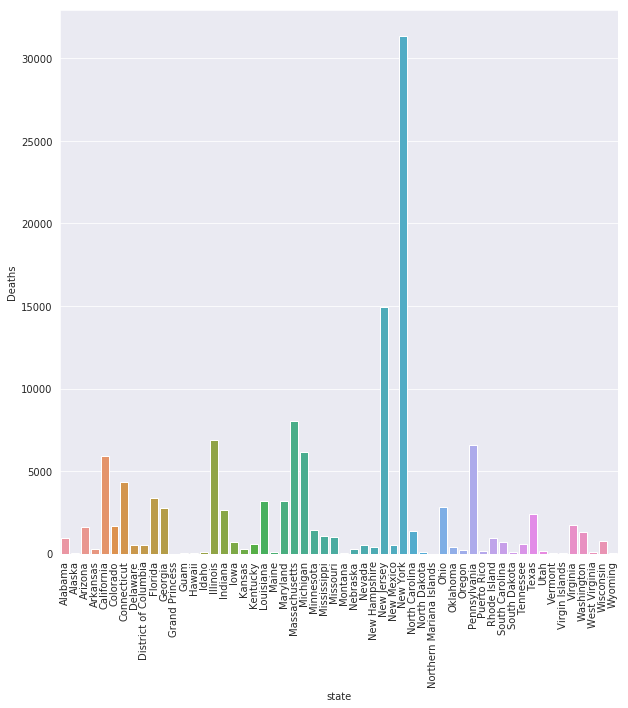

In [64]:
df_us.loc[:, 'state'] = df_us['state'].map(map_us_state_abbreviation_to_state_name)
df_us = df_us.dropna(subset=['state'])
df5 = df_us[df_us.date == yesterday].groupby('state').sum()
sns.barplot(x=df5.index, y=df5['Deaths'])
plt.xticks(rotation=90)
plt.show()

#### Active Cases 

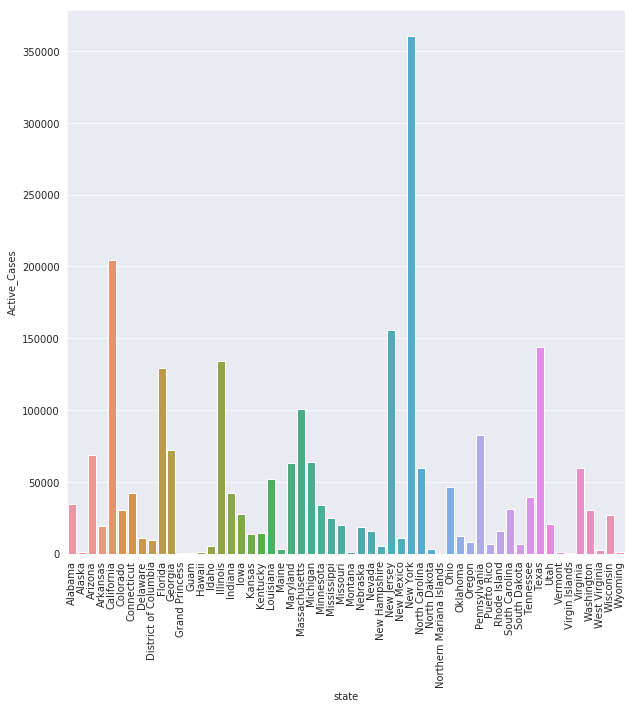

In [65]:
sns.barplot(x=df5.index, y=df5['Active_Cases'])
plt.xticks(rotation=90)
plt.show()

### Global Confirmed Cases

In [66]:
base_dir = '../data/Global/csse_covid_19_time_series/'
abs_path = os.path.abspath(base_dir)
files = os.listdir(abs_path)
csv_files = filter(lambda file: '.csv' in file, files)
csv_abs_path = [os.path.join(abs_path, csv_file) for csv_file in csv_files]
csv_abs_path = sorted(csv_abs_path)
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]

In [67]:
df_global_confirmed = pd.DataFrame(l, columns=columns)
df_global_confirmed_min = df_global_confirmed.drop(columns=['Province/State', 'Lat', 'Long'])
list_of_columns = [col for col in df_global_confirmed_min.columns if 'Country' not in col]
df_trans = df_global_confirmed_min.transpose()
df_trans.columns = df_trans.iloc[0, :]
df_trans = df_trans.iloc[1:, :]
df_trans = df_trans.astype(np.int)
df_trans.index = pd.to_datetime(df_trans.index)

#### Cleaning data for UK and Netherlands

In [68]:
df_uk = df_trans['United Kingdom']
flag = [False, False, False, False, False, False, True, False, False, False, False, False]
df_trans['UK'] = df_uk.loc[:, flag]
df_netherlands = df_trans['Netherlands']
flag = [False, False, False, True]
df_trans['Holland'] = df_netherlands.loc[:, flag]

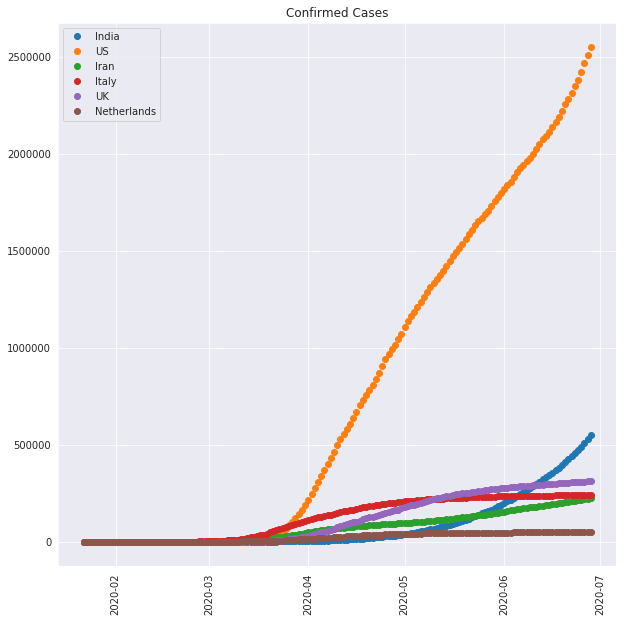

In [69]:
plt.plot_date(x=df_trans.index, y=df_trans['India'], label='India')
plt.plot_date(x=df_trans.index, y=df_trans['US'], label='US')
plt.plot_date(x=df_trans.index, y=df_trans['Iran'], label='Iran')
plt.plot_date(x=df_trans.index, y=df_trans['Italy'], label='Italy')
plt.plot_date(x=df_trans.index, y=df_trans['UK'], label='UK')
plt.plot_date(x=df_trans.index, y=df_trans['Holland'], label='Netherlands')
plt.xticks(rotation=90)
plt.title('Confirmed Cases')
plt.legend()
plt.show()

### Global Deaths

In [70]:
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]
df_global_deaths = pd.DataFrame(l, columns=columns)
df_global_deaths_min = df_global_deaths.drop(columns=['Province/State', 'Lat', 'Long'])
list_of_columns = [col for col in df_global_confirmed_min.columns if 'Country' not in col]
df_trans_deaths = df_global_deaths_min.transpose()
df_trans_deaths.columns = df_trans_deaths.iloc[0, :]
df_trans_deaths = df_trans_deaths.iloc[1:, :]
df_trans_deaths = df_trans_deaths.astype(np.int)
df_trans_deaths.index = pd.to_datetime(df_trans_deaths.index)

#### Cleaning data for UK and Netherlands

In [71]:
df_trans_deaths.columns[df_trans_deaths.columns == 'Netherlands']
df_uk = df_trans_deaths['United Kingdom']
flag = [False, False, False, False, False, False, True, False, False, False, False, False]
df_trans_deaths['UK'] = df_uk.loc[:, flag]
df_netherlands = df_trans_deaths['Netherlands']
flag = [False, False, False, True]
df_trans_deaths['Holland'] = df_netherlands.loc[:, flag]

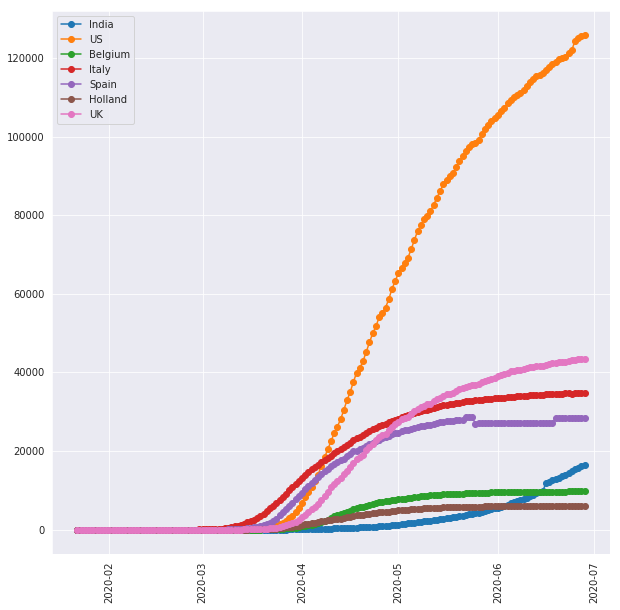

In [72]:
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['India'], label='India', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['US'], label='US', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Belgium'], label='Belgium', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Italy'], label='Italy', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Spain'], label='Spain', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Holland'], label='Holland', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['UK'], label='UK', linestyle='solid')
# plt.plot_date(x=df_trans.index, y=df_trans['China'], label='China', linestyle='solid')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Global Recovery

In [73]:
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_recovered_global.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]
df_global_recovered = pd.DataFrame(l, columns=columns)
df_global_recovered_min = df_global_recovered.drop(columns=['Province/State', 'Lat', 'Long'])
list_of_columns = [col for col in df_global_recovered_min.columns if 'Country' not in col]
df_trans_recovered = df_global_recovered_min.transpose()
df_trans_recovered.columns = df_trans_recovered.iloc[0, :]
df_trans_recovered = df_trans_recovered.iloc[1:, :]
df_trans_recovered = df_trans_recovered.astype(np.int)
df_trans_recovered.index = pd.to_datetime(df_trans_recovered.index)

In [74]:
df_trans_recovered.columns[df_trans_recovered.columns == 'Netherlands']
df_uk = df_trans_recovered['United Kingdom']
flag = [False, False, False, False, False, False, True, False, False, False, False, False]
df_trans_recovered['UK'] = df_uk.loc[:, flag]
df_netherlands = df_trans_recovered['Netherlands']
flag = [False, False, False, True]
df_trans_recovered['Holland'] = df_netherlands.loc[:, flag]

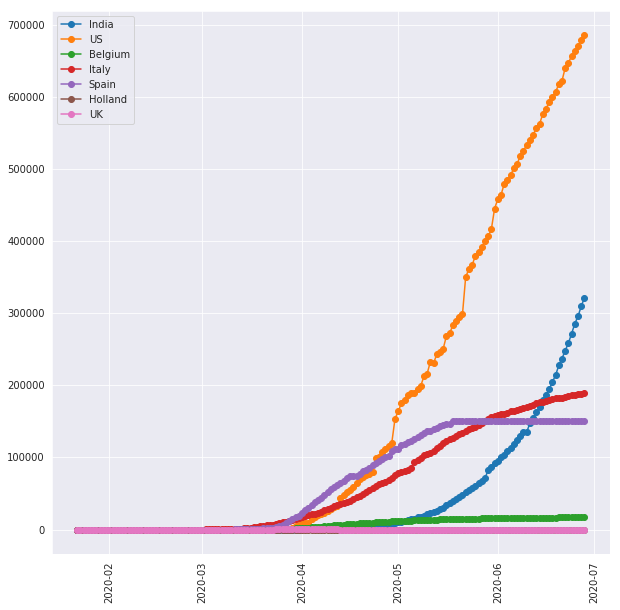

In [75]:
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['India'], label='India', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['US'], label='US', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Belgium'], label='Belgium', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Italy'], label='Italy', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Spain'], label='Spain', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Holland'], label='Holland', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['UK'], label='UK', linestyle='solid')
# plt.plot_date(x=df_trans.index, y=df_trans['China'], label='China', linestyle='solid')
# plt.plot_date(x=df_trans.index, y=df_trans['United Kingdom'], label='UK', linestyle='solid')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Comparing Confirmed vs Recovered vs Deaths for selected countries

### India

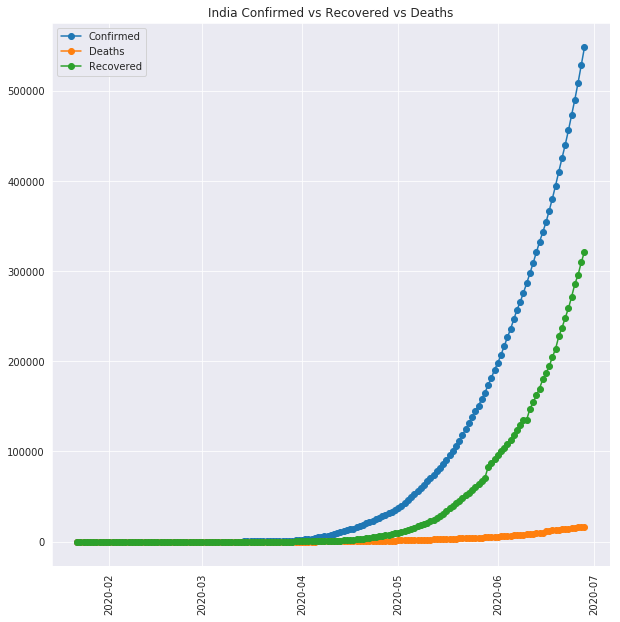

In [76]:
plt.plot_date(x=df_trans.index, y=df_trans['India'], label='Confirmed', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['India'], label='Deaths', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['India'], label='Recovered', linestyle='solid')

plt.xticks(rotation=90)
plt.legend()
plt.title('India Confirmed vs Recovered vs Deaths')
plt.show()

### UK

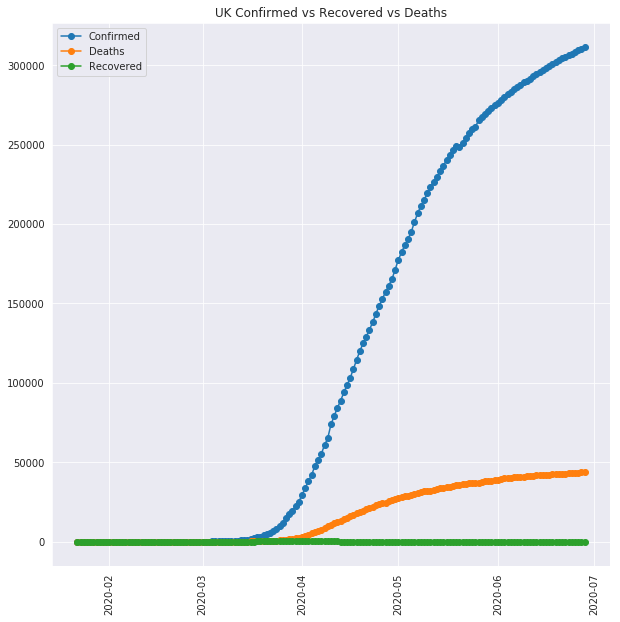

In [77]:
plt.plot_date(x=df_trans.index, y=df_trans['UK'], label='Confirmed', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['UK'], label='Deaths', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['UK'], label='Recovered', linestyle='solid')

plt.xticks(rotation=90)
plt.legend()
plt.title('UK Confirmed vs Recovered vs Deaths')
plt.show()

### US

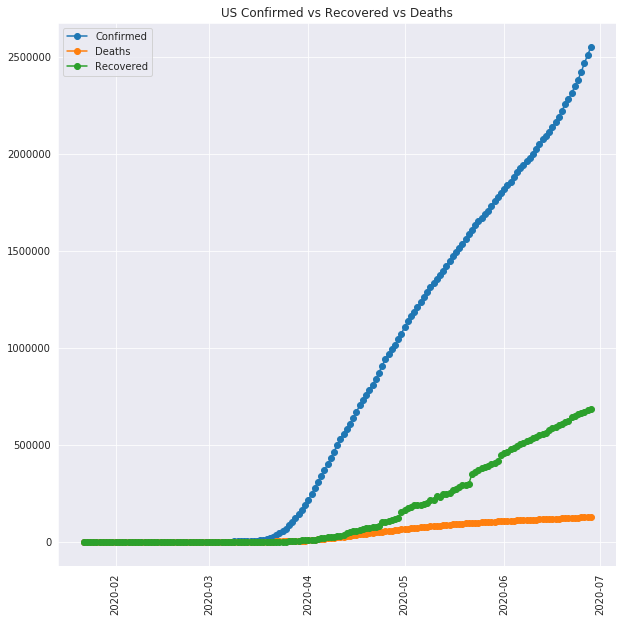

In [78]:
plt.plot_date(x=df_trans.index, y=df_trans['US'], label='Confirmed', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['US'], label='Deaths', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['US'], label='Recovered', linestyle='solid')

plt.xticks(rotation=90)
plt.legend()
plt.title('US Confirmed vs Recovered vs Deaths')
plt.show()

### Holland

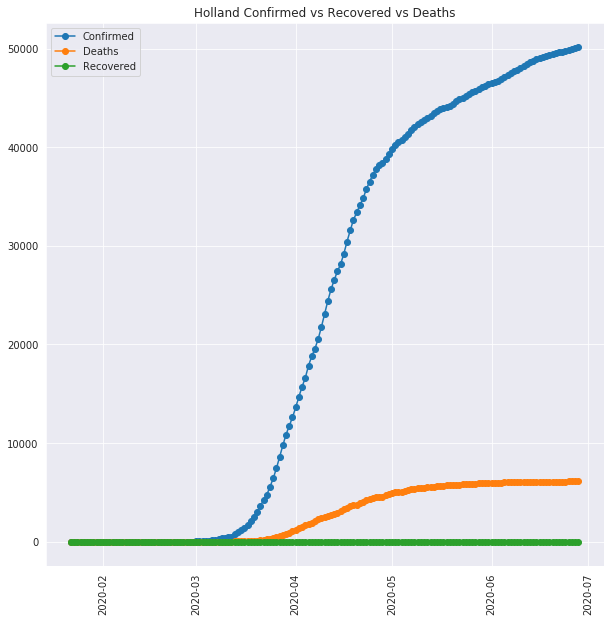

In [79]:
plt.plot_date(x=df_trans.index, y=df_trans['Holland'], label='Confirmed', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Holland'], label='Deaths', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Holland'], label='Recovered', linestyle='solid')

plt.xticks(rotation=90)
plt.legend()
plt.title('Holland Confirmed vs Recovered vs Deaths')
plt.show()

### India's fight against corona virus

### Active Cases

In [80]:
df_india = df1.loc[df1.Country_Region == 'India'].groupby(['Country_Region', 'date']).sum().reset_index()

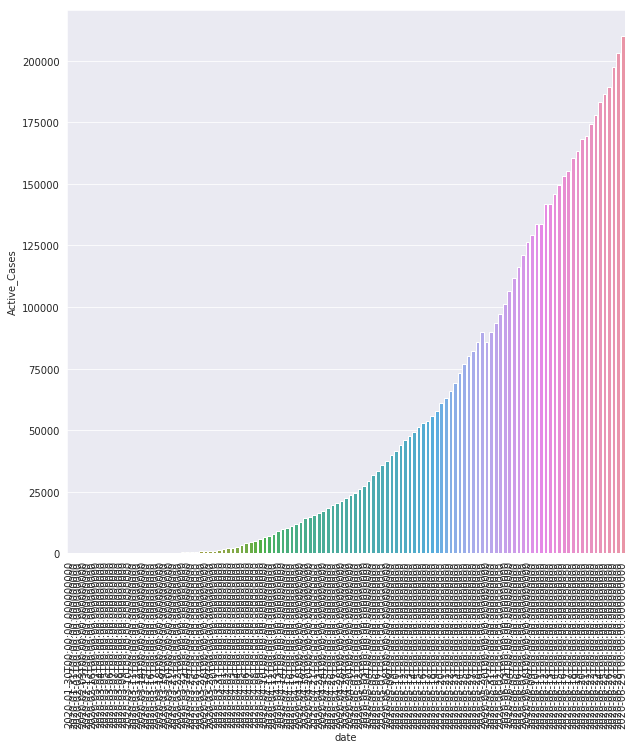

In [81]:
sns.barplot(x='date', y='Active_Cases', data=df_india)
plt.xticks(rotation=90)
# plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])
plt.show()

### Deaths

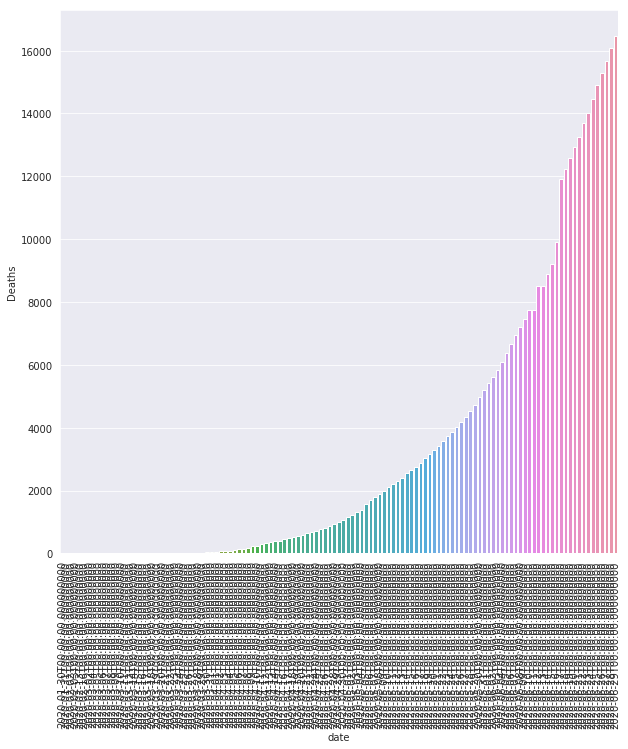

In [82]:
sns.barplot(x='date', y='Deaths', data=df_india)
plt.xticks(rotation=90)
# plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])
plt.show()

### Recovery

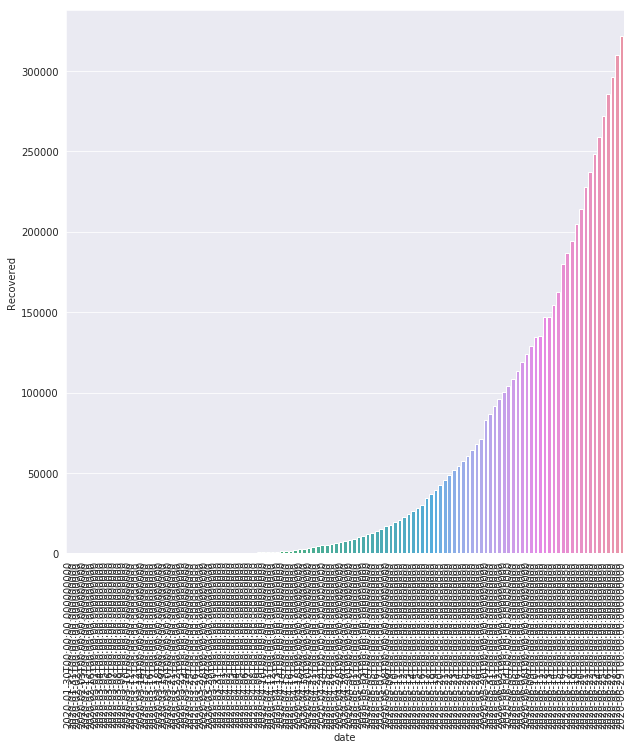

In [83]:
sns.barplot(x='date', y='Recovered', data=df_india)
plt.xticks(rotation=90)
# plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])
plt.show()

## Comparing India and New York Graphs

- Is India following New York trajectory?

#### India vs New York Confirmed Cases

In [84]:
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]

In [85]:
df_us_confirmed = pd.DataFrame(l, columns=columns)
df_us_confirmed_min = df_us_confirmed.drop(columns=['Country_Region', 'Lat', 'Long_', 'UID', 'iso2', 'iso3', 'code3',
                                                   'FIPS','Admin2', 'Combined_Key'])
list_of_columns = [col for col in df_us_confirmed_min.columns if 'State' not in col]
df_trans_us_confirmed = df_us_confirmed_min.transpose()
df_trans_us_confirmed.columns = df_trans_us_confirmed.iloc[0, :]
df_trans_us_confirmed = df_trans_us_confirmed.iloc[1:, :]
df_trans_us_confirmed = df_trans_us_confirmed.astype(np.int)
df_trans_us_confirmed.index = pd.to_datetime(df_trans_us_confirmed.index)
df_trans_us_confirmed['NY'] = df_trans_us_confirmed['New York'].agg(np.sum, axis=1)

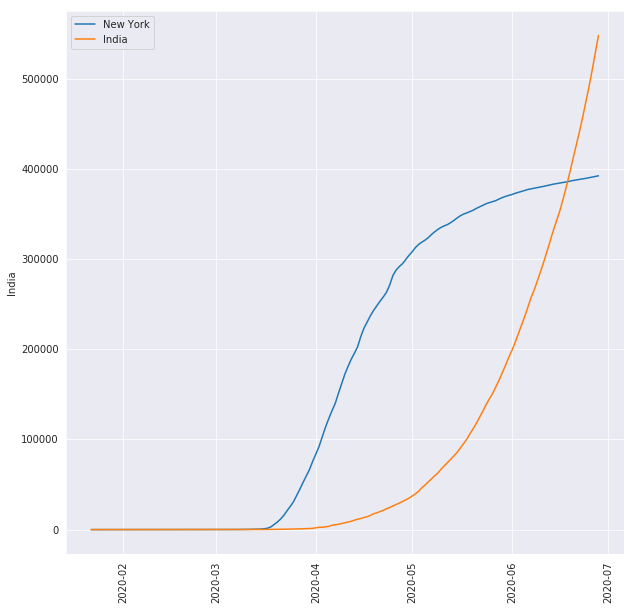

In [86]:
sns.lineplot(x=df_trans_us_confirmed.index, y=df_trans_us_confirmed['NY'], label='New York')
sns.lineplot(x=df_trans.index, y=df_trans['India'], label='India')
plt.xticks(rotation=90)
plt.legend()
plt.show()

#### Yes, India's trajectory is similar to New York. Only difference is that New York has reached the peak, whereas India is still on the rise.

#### India vs New York Deaths

In [87]:
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_deaths_US.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]

In [88]:
df_us_deaths = pd.DataFrame(l, columns=columns)
df_us_deaths_min = df_us_deaths.drop(columns=['Country_Region', 'Lat', 'Long_', 'UID', 'iso2', 'iso3', 'code3',
                                                   'FIPS','Admin2', 'Combined_Key', 'Population'])
list_of_columns = [col for col in df_us_deaths_min.columns if 'State' not in col]
df_trans_us_deaths = df_us_deaths_min.transpose()
df_trans_us_deaths.columns = df_trans_us_deaths.iloc[0, :]
df_trans_us_deaths = df_trans_us_deaths.iloc[1:, :]
df_trans_us_deaths = df_trans_us_deaths.astype(np.int)
df_trans_us_deaths.index = pd.to_datetime(df_trans_us_deaths.index)
df_trans_us_deaths['NY'] = df_trans_us_deaths['New York'].agg(np.sum, axis=1)

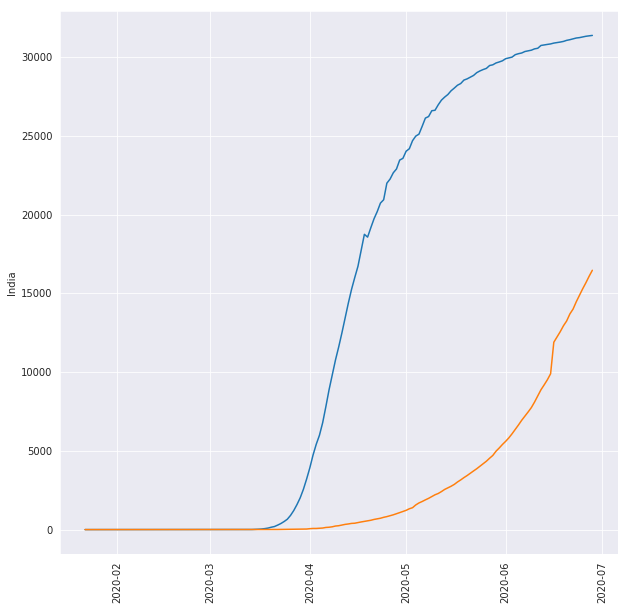

In [89]:
sns.lineplot(x=df_trans_us_deaths.index, y=df_trans_us_deaths['NY'])
sns.lineplot(x=df_trans_deaths.index, y=df_trans_deaths['India'])
plt.xticks(rotation=90)
plt.show()

### Time Series Forecasting using ARIMA model


In [90]:
def get_list_of_arma_model_parameters(df, no_of_lags):
    """ Helper Function to return list of tuple of ARMA params like (ar, ma, aic, bic)"""
    list_tup = []
    for i in range(10):
        for j in range(10):
            try:
                ARIMA_model = ARIMA(df, order=(i, no_of_lags, j)).fit(transparams=False)
                t = tuple([i, j, ARIMA_model.aic, ARIMA_model.bic])
                list_tup.append(t)
            except Exception as e:
                print(e)
    return list_tup

In [91]:
def get_best_ar_ma_value(list_of_tup):
    """ Helper Function to return best fit params from list of tuple of ARMA params like (ar, ma, aic, bic)"""
    least_bic = list_tup[0][3]
    best_params = list_tup[0]
    list_of_best_params = []
    for tup in list_of_tup:
        if tup[3] < least_bic:
            best_params = tup
            least_bic = tup[3]
    return best_params

### US Deaths

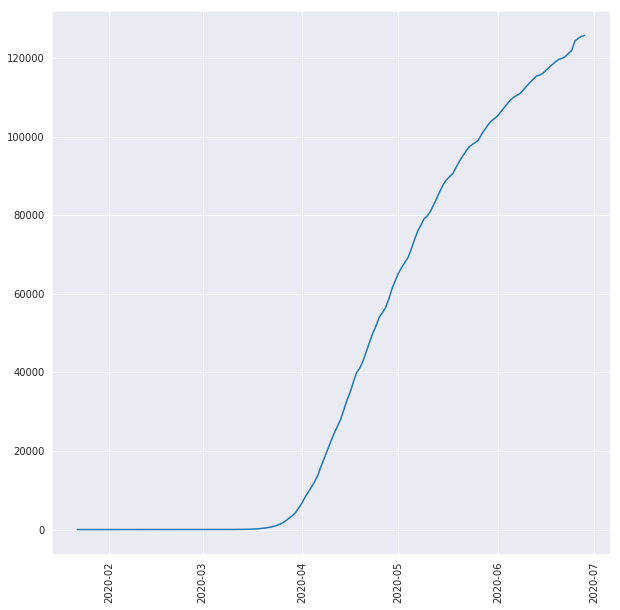

In [92]:
df_trans_deaths_us = df_trans_deaths[['US']]
plt.plot(df_trans_deaths_us)
plt.xticks(rotation=90)
plt.show()

In [93]:
df_us1 = df_trans_deaths_us.diff().fillna(df_trans_deaths_us)
df_us1.tail()

Country/Region,US
2020-06-24,754.0
2020-06-25,2425.0
2020-06-26,629.0
2020-06-27,500.0
2020-06-28,264.0


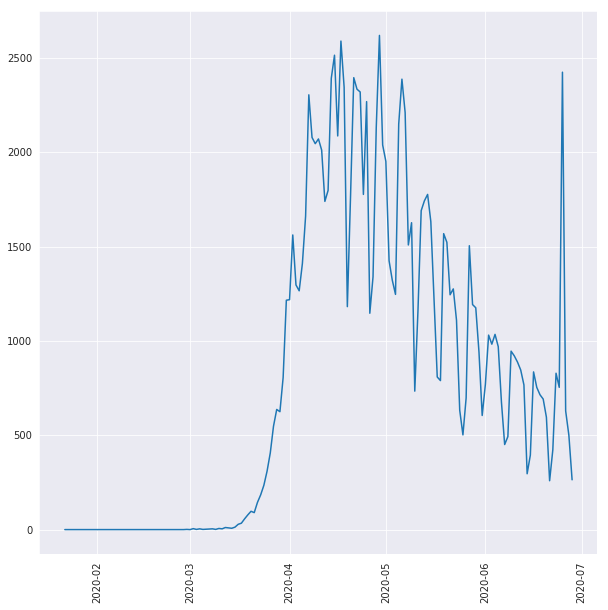

In [94]:
plt.plot(df_us1)
plt.xticks(rotation=90)
plt.show()

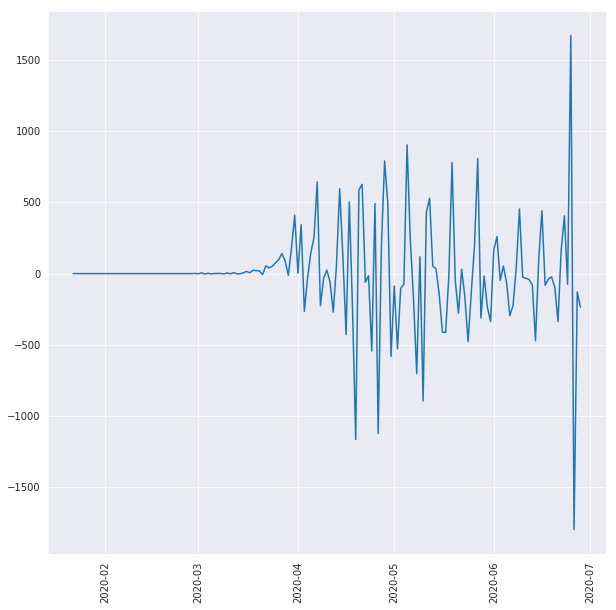

In [95]:
df_us2 = df_us1.diff().fillna(df_us1)
plt.plot(df_us2)
plt.xticks(rotation=90)
plt.show()

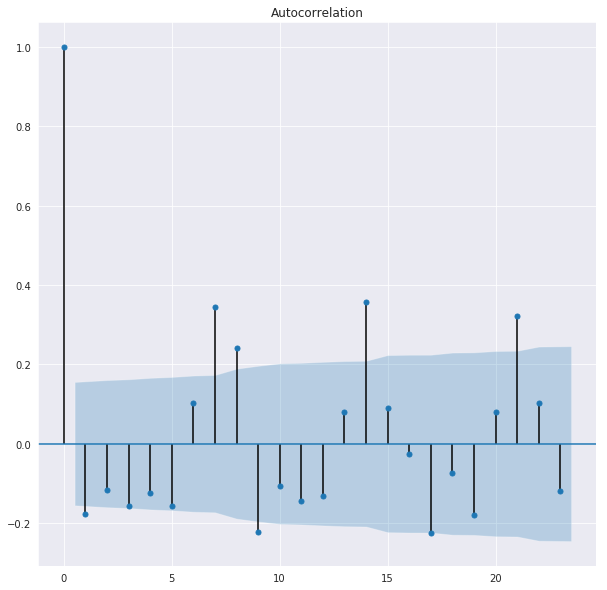

In [96]:
plot_acf(df_us2)
plt.show()

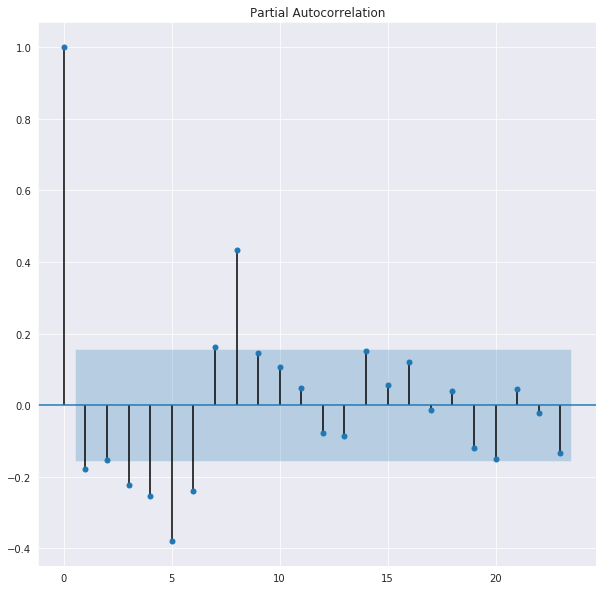

In [97]:
plot_pacf(df_us2)
plt.show()

In [98]:
list_tup = get_list_of_arma_model_parameters(df_trans_deaths_us, 2)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was pr

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was pr

On entry to DLASCL parameter number 4 had an illegal value
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params a

SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [99]:
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)

In [100]:
ARIMA_model = ARIMA(df_trans_deaths_us, order=(ar, 2, ma)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [101]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D2.US   No. Observations:                  157
Model:                 ARIMA(8, 2, 1)   Log Likelihood               -1083.918
Method:                       css-mle   S.D. of innovations            236.794
Date:                Mon, 29 Jun 2020   AIC                           2189.837
Time:                        21:35:43   BIC                           2223.456
Sample:                    01-24-2020   HQIC                          2203.491
                         - 06-28-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.7019     16.918      0.337      0.736     -27.458      38.861
ar.L1.D2.US    -0.2004      0.112     -1.790      0.073      -0.420       0.019
ar.L2.D2.US    -0.1465      0.072     -2.027      0.043      -0.288      -0.005
ar.L3.D2.US    -0.0995      0.067     -1.480      0.139      -0.231       0.032
ar.L4.D2.US    -0.0490      0.077     -0.637      0.524      -0.200       0.102
ar.L5.D2.US    -0.1052      0.077     -1.363      0.173      -0.257       0.046
ar.L6.D2.US     0.1757      0.079      2.212      0.027       0.020       0.331
ar.L7.D2.US     0.4549      0.074      6.154      0.000       0.310       0.600
ar.L8.D2.US     0.4485      0.093      4.812      0.000       0.266       0.631
ma.L1.D2.US    -0.5016      0.112     -4.473      0.000      -0.721      -0.282
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0652           -0.0000j            1.0652           -0.0000
AR.2            0.6335           -0.7897j            1.0124           -0.1424
AR.3            0.6335           +0.7897j            1.0124            0.1424
AR.4           -0.1666           -1.0692j            1.0821           -0.2746
AR.5           -0.1666           +1.0692j            1.0821            0.2746
AR.6           -1.1713           -0.0000j            1.1713           -0.5000
AR.7           -0.9209           -0.8005j            1.2202           -0.3861
AR.8           -0.9209           +0.8005j            1.2202            0.3861
MA.1            1.9935           +0.0000j            1.9935            0.0000
-----------------------------------------------------------------------------
"""

In [102]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-07-15', typ='levels')

In [103]:
arma_predict

2020-06-05    109490.524947
2020-06-06    110249.226783
2020-06-07    110674.158705
2020-06-08    111146.289002
2020-06-09    111839.020821
2020-06-10    112925.781645
2020-06-11    113821.532757
2020-06-12    114641.868062
2020-06-13    115290.787004
2020-06-14    115885.129743
2020-06-15    116220.384202
2020-06-16    116854.905284
2020-06-17    117886.054171
2020-06-18    118498.528930
2020-06-19    119156.210055
2020-06-20    119684.074574
2020-06-21    120052.753666
2020-06-22    120283.655577
2020-06-23    121030.521702
2020-06-24    122051.330443
2020-06-25    122682.521664
2020-06-26    125589.798222
2020-06-27    125919.398974
2020-06-28    126148.878629
2020-06-29    126409.219791
2020-06-30    127154.505709
2020-07-01    128485.075106
2020-07-02    130083.055056
2020-07-03    131448.654801
2020-07-04    131817.899676
2020-07-05    132248.768197
2020-07-06    132838.951825
2020-07-07    133793.138742
2020-07-08    135096.762050
2020-07-09    136709.297135
2020-07-10    138000

In [104]:
undiff1 = df_us2.cumsum().fillna(df_us2)
undiff2 = df_us1.cumsum().fillna(df_us1)

### Mean Absolute Error for Forecast Evaluation

In [105]:
arma_predict2 = ARIMA_model.predict('2020-01-24', '2020-07-25', typ='levels')
ser2 = arma_predict2

In [106]:
ser2.diff()

2020-01-24            NaN
2020-01-25       0.552812
2020-01-26       0.852818
2020-01-27       2.117178
2020-01-28       2.815467
2020-01-29       5.690231
2020-01-30       5.097571
2020-01-31      -3.196320
2020-02-01      -9.769003
2020-02-02      -2.288827
2020-02-03      -0.866371
2020-02-04      -0.383210
2020-02-05      -0.181049
2020-02-06      -0.088196
2020-02-07      -0.043604
2020-02-08      -0.021715
2020-02-09      -0.010854
2020-02-10      -0.005435
2020-02-11      -0.002724
2020-02-12      -0.001366
2020-02-13      -0.000685
2020-02-14      -0.000344
2020-02-15      -0.000172
2020-02-16      -0.000086
2020-02-17      -0.000043
                 ...     
2020-07-01    1330.569397
2020-07-02    1597.979951
2020-07-03    1365.599745
2020-07-04     369.244875
2020-07-05     430.868521
2020-07-06     590.183628
2020-07-07     954.186918
2020-07-08    1303.623308
2020-07-09    1612.535085
2020-07-10    1291.084932
2020-07-11     697.180467
2020-07-12     389.238686
2020-07-13  

### Note:

- The model predicted number of deaths on 13th June as 648.
- Actual number of deaths on 13th June: 654

#### Note the predicted trajectory in blue.

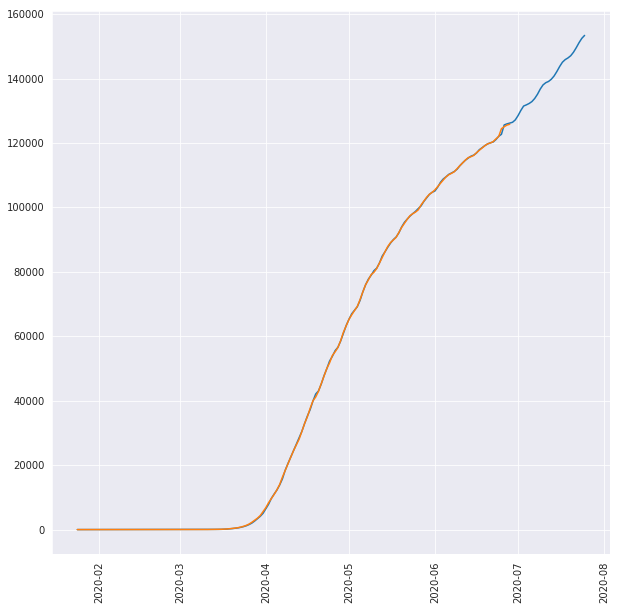

In [107]:
actual = df_trans_deaths_us.loc['2020-01-24':, :]
plt.plot(ser2)
plt.plot(actual)
plt.xticks(rotation=90)
plt.show()

# India

### India Deaths

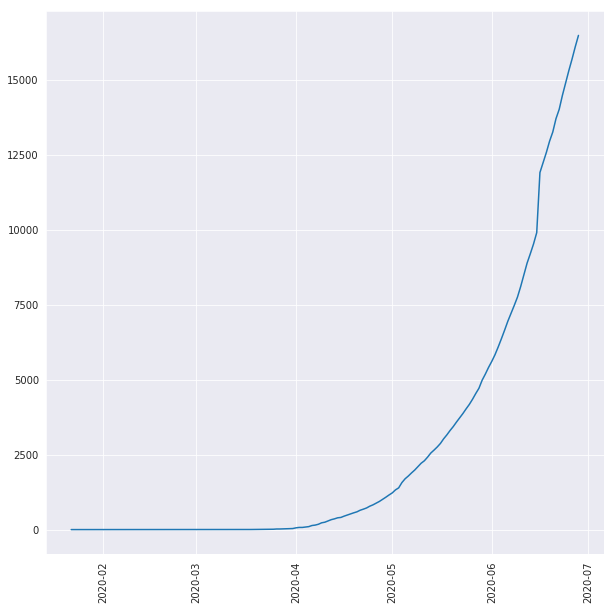

In [108]:
df_trans_deaths_ind = df_trans_deaths[['India']]
plt.plot(df_trans_deaths_ind)
plt.xticks(rotation=90)
plt.show()

In [109]:
temp = np.log(df_trans_deaths_ind)
temp = temp[temp.India != -np.inf]

/home/akash/Dev/python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [110]:
temp.head()

Country/Region,India
2020-03-11,0.000000
2020-03-12,0.000000
2020-03-13,0.693147
2020-03-14,0.693147
2020-03-15,0.693147


In [111]:
df_deaths_ind = df_trans_deaths_ind

In [112]:
df_trans_deaths_ind = temp[temp.India != -np.inf]

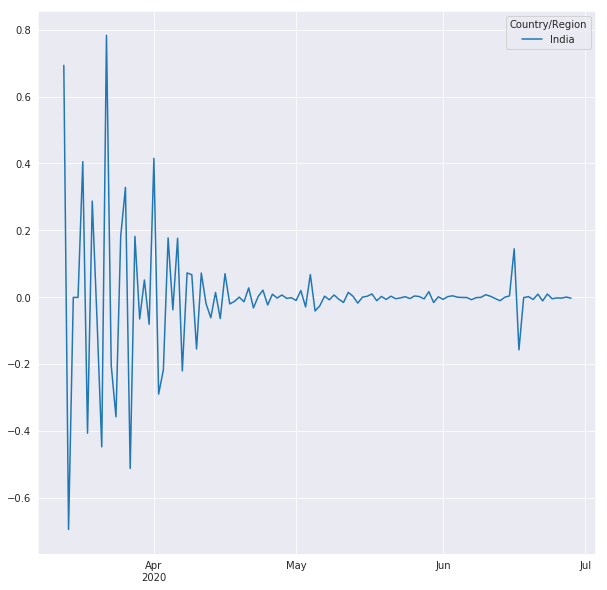

In [113]:
df_trans_deaths_ind.diff().dropna().diff().dropna().plot()

In [114]:
df_ind1 = df_trans_deaths_ind.diff().fillna(df_trans_deaths_ind)
df_ind1.tail()

Country/Region,India
2020-06-24,0.028466
2020-06-25,0.026960
2020-06-26,0.024787
2020-06-27,0.025804
2020-06-28,0.023335


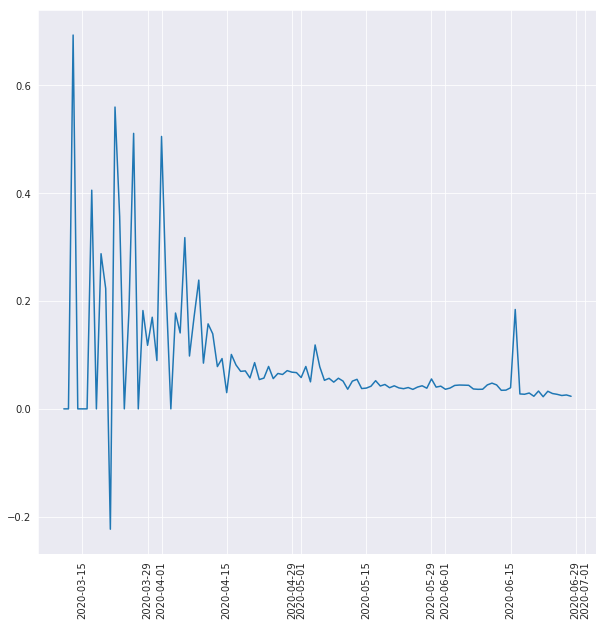

In [115]:
plt.plot(df_ind1)
plt.xticks(rotation=90)
plt.show()

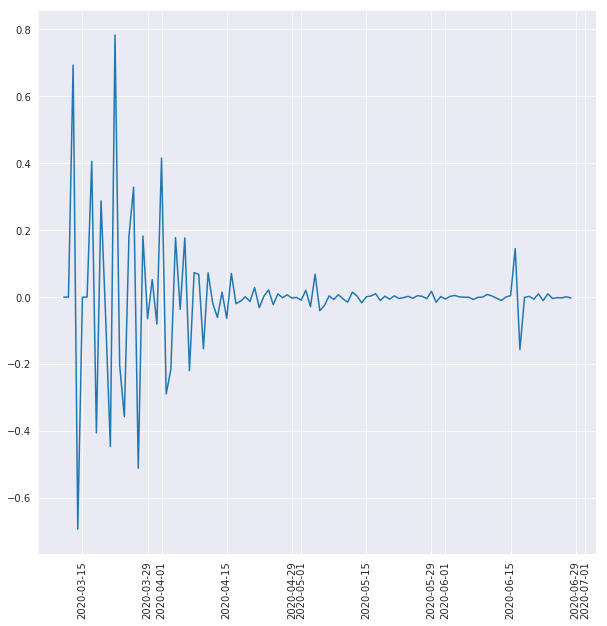

In [116]:
df_ind2 = df_ind1.diff().fillna(df_ind1)
plt.plot(df_ind2)
plt.xticks(rotation=90)
plt.show()

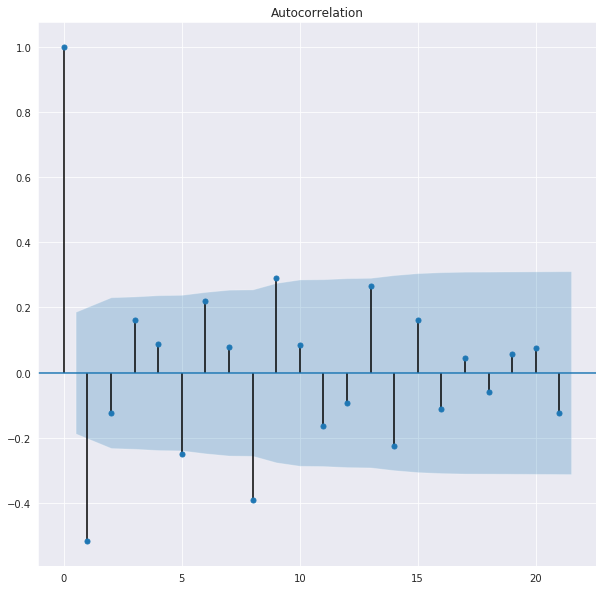

In [117]:
plot_acf(df_ind2)
plt.show()

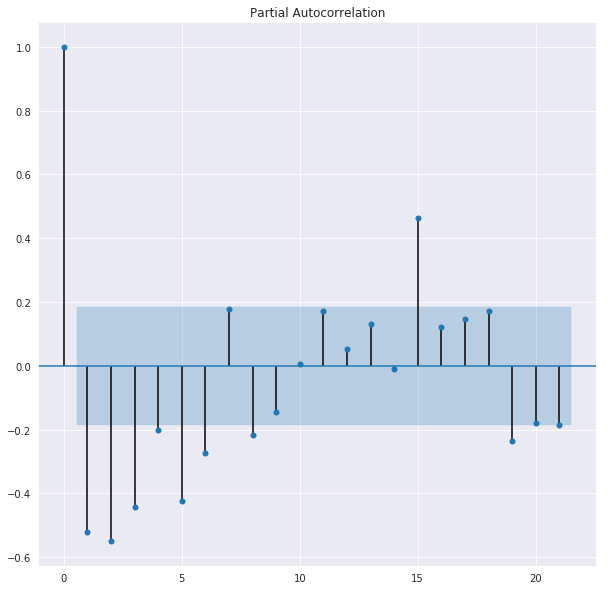

In [118]:
plot_pacf(df_ind2)
plt.show()

In [119]:
list_tup = get_list_of_arma_model_parameters(df_deaths_ind, 2)
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are 

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

On entry to DLASCL parameter number 4 had an illegal value
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so 

In [120]:
ARIMA_model = ARIMA(df_deaths_ind, order=(ar, 2, ma)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [121]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.India   No. Observations:                  157
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -999.351
Method:                       css-mle   S.D. of innovations            140.008
Date:                Mon, 29 Jun 2020   AIC                           2004.701
Time:                        21:36:54   BIC                           2013.870
Sample:                    01-24-2020   HQIC                          2008.425
                         - 06-28-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.9035      1.448      2.005      0.045       0.065       5.742
ma.L1.D2.India    -0.8765      0.035    -24.877      0.000      -0.946      -0.807
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.1409           +0.0000j            1.1409            0.0000
-----------------------------------------------------------------------------
"""

In [122]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-08-15', typ='levels')

In [123]:
undiff1 = df_ind2.cumsum().fillna(df_ind2)
undiff2 = df_ind1.cumsum().fillna(df_ind1)

### Mean Absolute Error for Forecast Evaluation

In [124]:
arma_predict2 = ARIMA_model.predict('2020-01-24', '2020-07-15', typ='levels')
ser2 = arma_predict2

In [125]:
ser2.diff()

2020-01-24           NaN
2020-01-25      1.439215
2020-01-26      1.414587
2020-01-27      1.378687
2020-01-28      1.332681
2020-01-29      1.277998
2020-01-30      1.216238
2020-01-31      1.149083
2020-02-01      1.078207
2020-02-02      1.005205
2020-02-03      0.931530
2020-02-04      0.858460
2020-02-05      0.787070
2020-02-06      0.718228
2020-02-07      0.652596
2020-02-08      0.590651
2020-02-09      0.532699
2020-02-10      0.478903
2020-02-11      0.429308
2020-02-12      0.383860
2020-02-13      0.342435
2020-02-14      0.304855
2020-02-15      0.270904
2020-02-16      0.240343
2020-02-17      0.212923
                 ...    
2020-06-21    286.993715
2020-06-22    445.511871
2020-06-23    296.019454
2020-06-24    469.893235
2020-06-25    416.482982
2020-06-26    404.311571
2020-06-27    378.802529
2020-06-28    408.656281
2020-06-29    375.116436
2020-06-30    441.058807
2020-07-01    443.962293
2020-07-02    446.865779
2020-07-03    449.769265
2020-07-04    452.672751


### Note:

- The model predicted number of deaths on 13th June as 648.
- Actual number of deaths on 13th June: 654

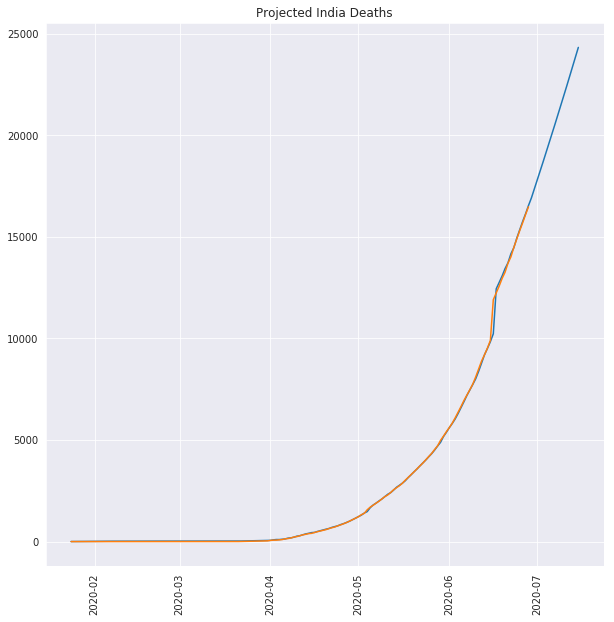

In [126]:
actual = df_deaths_ind.loc['2020-01-24':, :]
plt.plot(ser2)
plt.plot(actual)
plt.xticks(rotation=90)
plt.title('Projected India Deaths')
plt.show()

In [127]:
df_new = pd.DataFrame(actual)

In [128]:
df_new['predicted'] = ser2

In [129]:
df_new = df_new.rename(columns={"India":"actual"})

In [130]:
df_new.loc[:, 'error'] = np.absolute(df_new.predicted - df_new.actual)

In [131]:
df_new.tail()

Country/Region,actual,predicted,error
2020-06-24,14894,14929.785521,35.785521
2020-06-25,15301,15346.268503,45.268503
2020-06-26,15685,15750.580074,65.580074
2020-06-27,16095,16129.382603,34.382603
2020-06-28,16475,16538.038885,63.038885


In [132]:
df_new.loc[:, 'error_squared'] = np.square(df_new.predicted - df_new.actual)

In [133]:
sum(df_new.error_squared) / len(df_new)

19602.550221520076

In [134]:
np.sqrt(sum(df_new.error_squared) / len(df_new))

140.0091076377536

In [135]:
root_mean_square_error = np.sqrt(sum(df_new.error_squared) / len(df_new))

In [136]:
root_mean_square_error

140.0091076377536

### Forecast India's Active Cases

In [137]:
df_india_active = pd.DataFrame(df_trans.loc[:, 'India'])
df_india_active = df_india_active.rename({"India": 'Confirmed'}, axis='columns')

In [138]:
df_india_active['Recovered'] = df_trans_recovered.loc[:, 'India']

In [139]:
df_india_active['Active'] = df_india_active['Confirmed'] - df_india_active['Recovered']

In [140]:
df_india_active = df_india_active[['Active']]

In [141]:
df_temp = df_india_active
df_temp['exp'] = np.log10(df_india_active['Active'])

/home/akash/Dev/python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [142]:
df_temp = df_temp[df_temp.exp != -np.inf]

In [143]:
df_temp.tail()

,Active,exp
2020-06-24,201408,5.304077
2020-06-25,204764,5.311254
2020-06-26,213072,5.328526
2020-06-27,219146,5.340734
2020-06-28,226595,5.355250


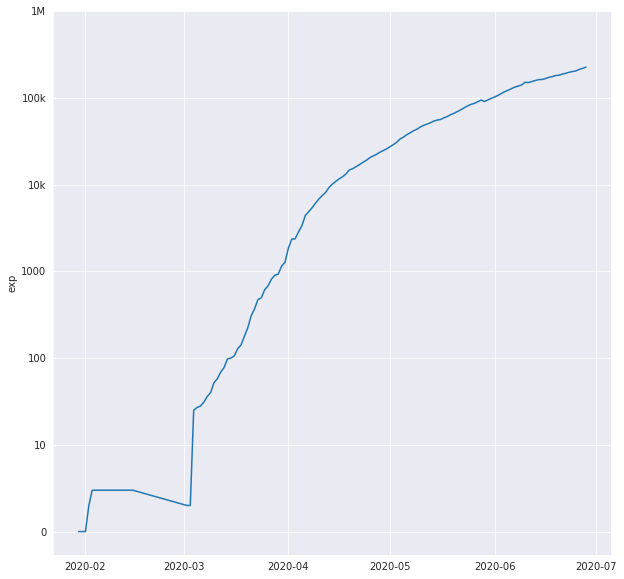

In [144]:
sns.lineplot(df_temp.index, df_temp.exp)
plt.yticks([0, 1, 2, 3, 4, 5, 6], ['0', '10', '100', '1000', '10k', '100k', '1M'])
plt.show()

In [145]:
# df_india_active = np.log(df_india_active)
# df_india_active = df_india_active[df_india_active != -np.inf]
df_india_active = df_india_active[['Active']]

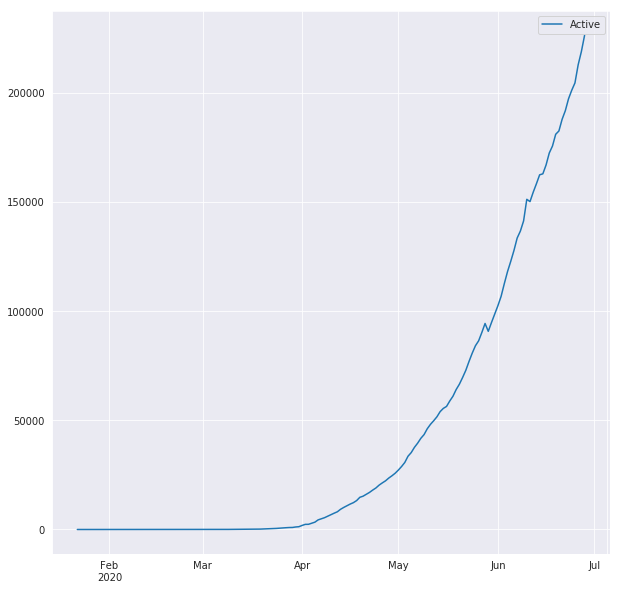

In [146]:
df_india_active.plot()

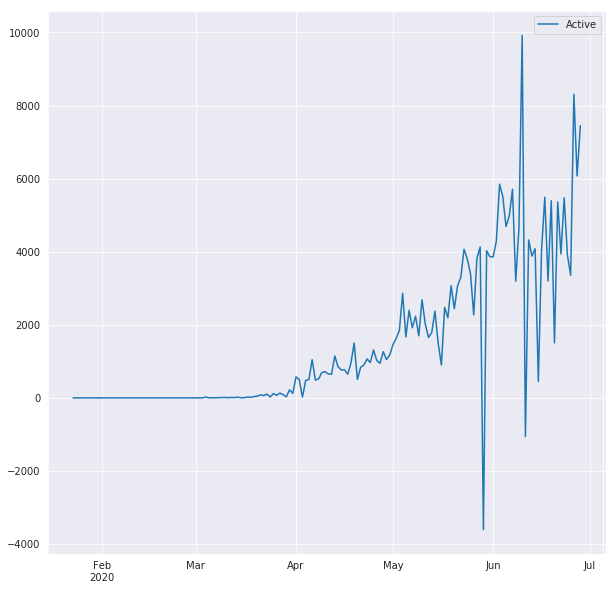

In [147]:
df_india_active.diff(periods=1).dropna().plot()

In [148]:
df_india_active_diff = df_india_active.diff(periods=1).dropna()['Active']

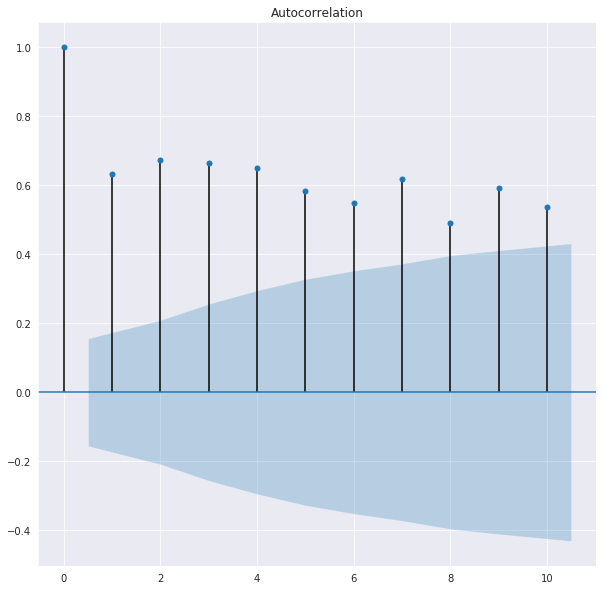

In [149]:
plot_acf(df_india_active_diff, lags=10)
plt.show()

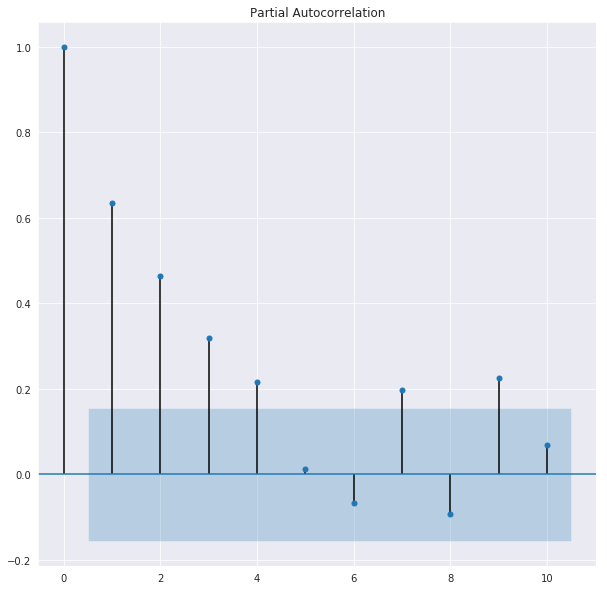

In [150]:
plot_pacf(df_india_active_diff, lags=10)
plt.show()

In [151]:
list_tup = get_list_of_arma_model_parameters(df_india_active_diff, 2)
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)
ARIMA_model = ARIMA(df_india_active, order=(ar, 2, ma)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was pr

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was pr

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was pr

On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own s

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov

On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

In [152]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D2.Active   No. Observations:                  157
Model:                 ARIMA(5, 2, 5)   Log Likelihood               -1307.914
Method:                       css-mle   S.D. of innovations            863.063
Date:                Mon, 29 Jun 2020   AIC                           2639.828
Time:                        21:40:11   BIC                           2676.503
Sample:                    01-24-2020   HQIC                          2654.723
                         - 06-28-2020                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              38.1440     13.686      2.787      0.005      11.319      64.969
ar.L1.D2.Active    -1.0202      0.198     -5.157      0.000      -1.408      -0.632
ar.L2.D2.Active    -0.4697      0.197     -2.384      0.017      -0.856      -0.084
ar.L3.D2.Active    -0.5964      0.182     -3.284      0.001      -0.952      -0.240
ar.L4.D2.Active    -0.0636      0.202     -0.315      0.753      -0.459       0.332
ar.L5.D2.Active     0.2903      0.104      2.789      0.005       0.086       0.494
ma.L1.D2.Active    -0.2138      0.181     -1.179      0.238      -0.569       0.142
ma.L2.D2.Active    -0.4807      0.175     -2.742      0.006      -0.824      -0.137
ma.L3.D2.Active     0.5711      0.080      7.124      0.000       0.414       0.728
ma.L4.D2.Active    -0.7603      0.146     -5.191      0.000      -1.047      -0.473
ma.L5.D2.Active    -0.6535      0.217     -3.009      0.003      -1.079      -0.228
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0890           -0.2847j            1.1256           -0.4593
AR.2           -1.0890           +0.2847j            1.1256            0.4593
AR.3            0.1447           -1.1264j            1.1357           -0.2297
AR.4            0.1447           +1.1264j            1.1357            0.2297
AR.5            2.1076           -0.0000j            2.1076           -0.0000
MA.1            0.8873           -0.0000j            0.8873           -0.0000
MA.2            0.3285           -0.9445j            1.0000           -0.1967
MA.3            0.3285           +0.9445j            1.0000            0.1967
MA.4           -1.0247           -0.0000j            1.0247           -0.5000
MA.5           -1.6830           -0.0000j            1.6830           -0.5000
-----------------------------------------------------------------------------
"""

In [153]:
ARIMA_model.predict('2020-02-24', '2020-07-15', typ='levels')

2020-02-24       214.803691
2020-02-25       225.452814
2020-02-26       234.924253
2020-02-27       243.914730
2020-02-28       228.530196
2020-02-29       223.222438
2020-03-01       223.184553
2020-03-02       239.243192
2020-03-03       241.960122
2020-03-04       237.698485
2020-03-05       248.107890
2020-03-06       260.847370
2020-03-07       275.285918
2020-03-08       278.035326
2020-03-09       267.288443
2020-03-10       259.266107
2020-03-11       286.323863
2020-03-12       306.323832
2020-03-13       323.950916
2020-03-14       312.182493
2020-03-15       326.822501
2020-03-16       332.987463
2020-03-17       363.300229
2020-03-18       374.327918
2020-03-19       383.862359
                  ...      
2020-06-21    188009.132469
2020-06-22    191380.411533
2020-06-23    196335.181908
2020-06-24    201185.299291
2020-06-25    206641.375910
2020-06-26    210169.946653
2020-06-27    216998.101874
2020-06-28    223442.041139
2020-06-29    231660.485817
2020-06-30    238209

In [154]:
arma_predict2 = ARIMA_model.predict('2020-03-24', '2020-07-15', typ='levels')
ser2 = arma_predict2

### Mean Absolute Error for Forecast Evaluation

In [155]:
actual = df_india_active.loc['2020-01-24':]

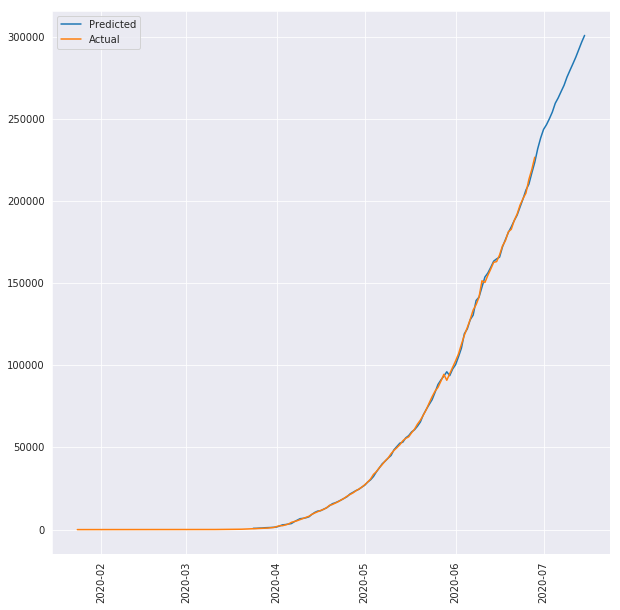

In [156]:
plt.plot(ser2, label='Predicted')
plt.plot(actual, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [157]:
df_new = pd.DataFrame(actual)

In [158]:
df_new['predicted'] = ser2

In [159]:
df_new.tail()

,Active,predicted
2020-06-24,201408,201185.299291
2020-06-25,204764,206641.375910
2020-06-26,213072,210169.946653
2020-06-27,219146,216998.101874
2020-06-28,226595,223442.041139


In [160]:
df_new.loc[:, 'error'] = np.absolute(df_new.predicted - df_new.Active)

In [161]:
df_new.tail()

,Active,predicted,error
2020-06-24,201408,201185.299291,222.700709
2020-06-25,204764,206641.375910,1877.375910
2020-06-26,213072,210169.946653,2902.053347
2020-06-27,219146,216998.101874,2147.898126
2020-06-28,226595,223442.041139,3152.958861


In [162]:
df_new.loc[:, 'error_squared'] = np.square(df_new.predicted - df_new.Active)

In [163]:
df_new = df_new.dropna()

In [164]:
sum(df_new.error_squared) / len(df_new)

1529553.979911337

In [165]:
np.sqrt(sum(df_new.error_squared) / len(df_new))

1236.7513816088247

In [166]:
root_mean_square_error = np.sqrt(sum(df_new.error_squared) / len(df_new))

In [167]:
root_mean_square_error

1236.7513816088247

### Forecast India's Confirmed Cases

### India Confirmed Cases

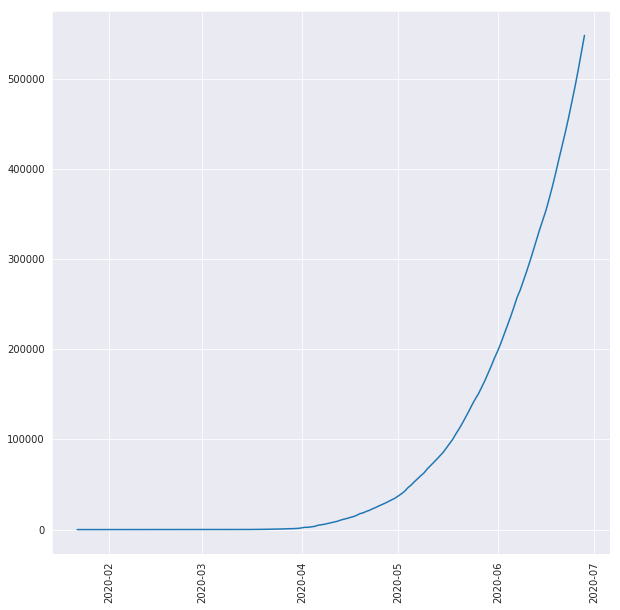

In [168]:
df_trans_confirmed_ind = df_trans[['India']]
plt.plot(df_trans_confirmed_ind)
plt.xticks(rotation=90)
plt.show()

In [169]:
df_ind1 = df_trans_confirmed_ind.diff().fillna(df_trans_confirmed_ind)
df_ind1.tail()

Country/Region,India
2020-06-24,16922.0
2020-06-25,17296.0
2020-06-26,18552.0
2020-06-27,19906.0
2020-06-28,19459.0


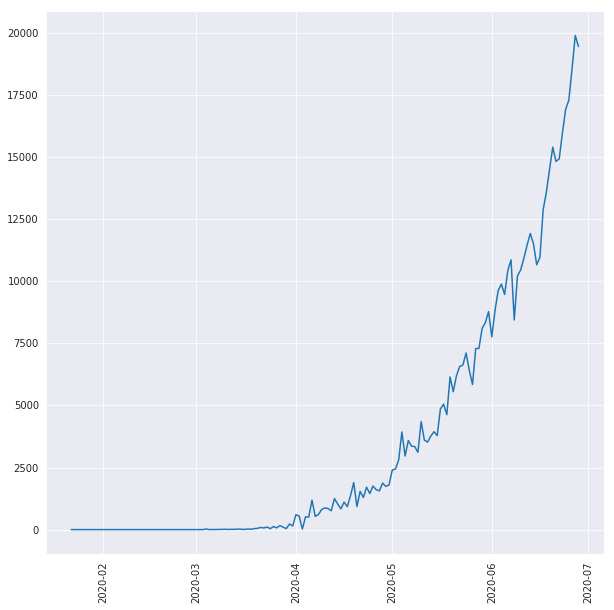

In [170]:
plt.plot(df_ind1)
plt.xticks(rotation=90)
plt.show()

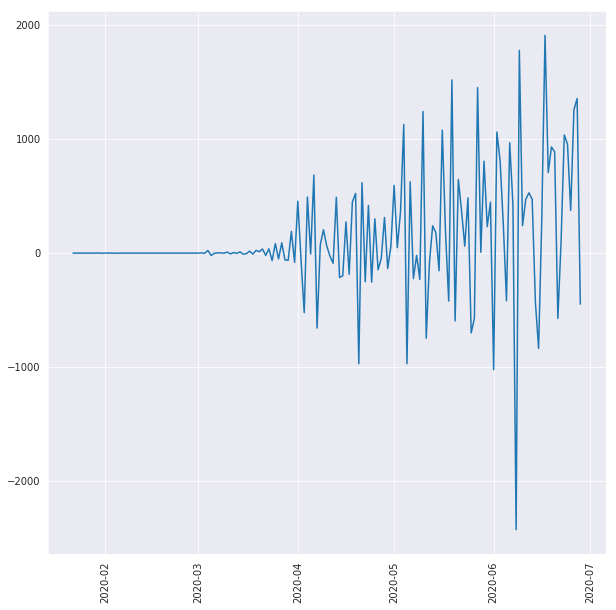

In [171]:
df_ind2 = df_ind1.diff().fillna(df_ind1)
plt.plot(df_ind2)
plt.xticks(rotation=90)
plt.show()

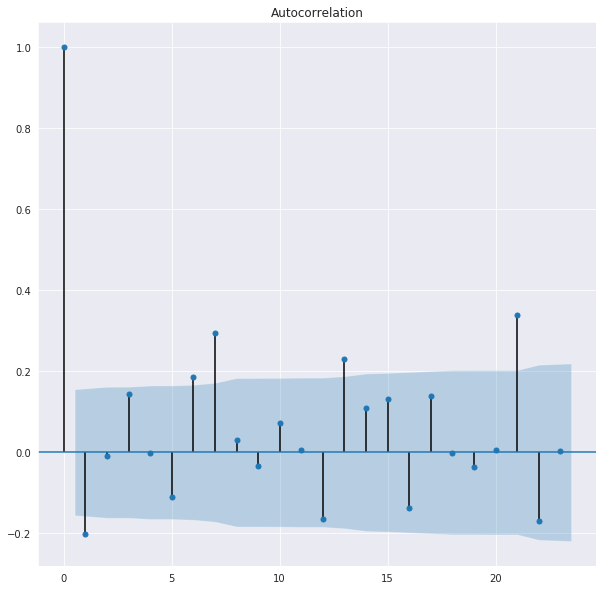

In [172]:
plot_acf(df_ind2)
plt.show()

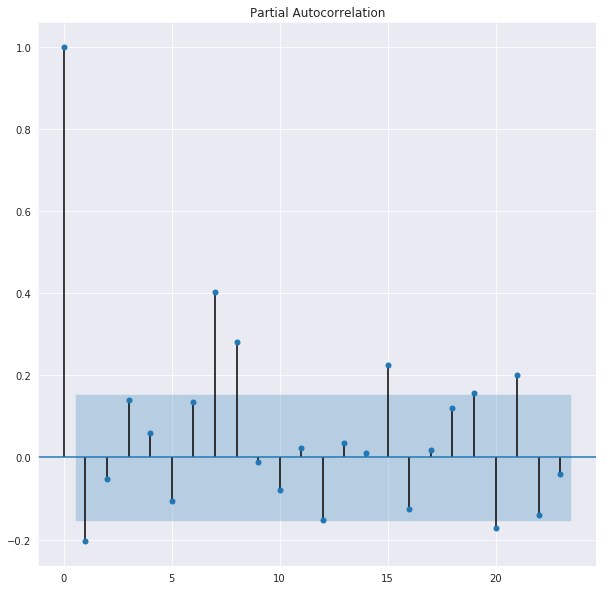

In [173]:
plot_pacf(df_ind2)
plt.show()

In [174]:
list_tup = get_list_of_arma_model_parameters(df_trans_confirmed_ind, 2)
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)
ARIMA_model = ARIMA(df_trans_confirmed_ind, order=(ar, 2, ma)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

SVD did not converge
SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
SVD did not converge
SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
SVD did not converge
SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params a

SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

SVD did not converge
SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SVD did not converge
SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


SVD did not converge


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so 

On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
On entry to DLASCL parameter number 4 had an illegal value
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


In [175]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.India   No. Observations:                  157
Model:                 ARIMA(9, 2, 0)   Log Likelihood               -1172.466
Method:                       css-mle   S.D. of innovations            418.953
Date:                Mon, 29 Jun 2020   AIC                           2366.932
Time:                        21:41:40   BIC                           2400.551
Sample:                    01-24-2020   HQIC                          2380.586
                         - 06-28-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            215.6904    177.871      1.213      0.225    -132.930     564.311
ar.L1.D2.India    -0.4339      0.080     -5.448      0.000      -0.590      -0.278
ar.L2.D2.India    -0.1022      0.083     -1.235      0.217      -0.264       0.060
ar.L3.D2.India     0.1304      0.070      1.862      0.063      -0.007       0.268
ar.L4.D2.India     0.0329      0.066      0.498      0.618      -0.096       0.162
ar.L5.D2.India    -0.0505      0.068     -0.748      0.455      -0.183       0.082
ar.L6.D2.India     0.2719      0.068      4.009      0.000       0.139       0.405
ar.L7.D2.India     0.5614      0.071      7.959      0.000       0.423       0.700
ar.L8.D2.India     0.3780      0.086      4.399      0.000       0.210       0.546
ar.L9.D2.India     0.0618      0.083      0.747      0.455      -0.100       0.224
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0162           -0.0000j            1.0162           -0.0000
AR.2            0.6546           -0.8356j            1.0615           -0.1442
AR.3            0.6546           +0.8356j            1.0615            0.1442
AR.4           -0.3037           -1.0697j            1.1120           -0.2940
AR.5           -0.3037           +1.0697j            1.1120            0.2940
AR.6           -1.0901           -0.8378j            1.3749           -0.3957
AR.7           -1.0901           +0.8378j            1.3749            0.3957
AR.8           -1.4310           -0.0000j            1.4310           -0.5000
AR.9           -4.2282           -0.0000j            4.2282           -0.5000
-----------------------------------------------------------------------------
"""

In [176]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-07-15', typ='levels')

In [177]:
arma_predict

2020-06-05    237129.432290
2020-06-06    246590.680400
2020-06-07    256831.770338
2020-06-08    267909.497384
2020-06-09    275966.810833
2020-06-10    286844.833449
2020-06-11    296862.140553
2020-06-12    308574.028560
2020-06-13    320934.960842
2020-06-14    332524.880720
2020-06-15    343511.619957
2020-06-16    354424.746752
2020-06-17    365741.804937
2020-06-18    379462.612114
2020-06-19    394301.257540
2020-06-20    409798.766053
2020-06-21    425289.411259
2020-06-22    439833.376337
2020-06-23    455654.133459
2020-06-24    472958.313995
2020-06-25    490877.909963
2020-06-26    508784.489465
2020-06-27    527844.971183
2020-06-28    548208.656331
2020-06-29    568170.150266
2020-06-30    588972.477797
2020-07-01    610312.335277
2020-07-02    632298.478279
2020-07-03    655414.758535
2020-07-04    679224.977872
2020-07-05    703150.261927
2020-07-06    727522.321167
2020-07-07    752616.788548
2020-07-08    778226.233351
2020-07-09    804529.830389
2020-07-10    831715

In [178]:
undiff1 = df_ind2.cumsum().fillna(df_ind2)
undiff2 = df_ind1.cumsum().fillna(df_ind1)

### Mean Absolute Error for Forecast Evaluation

In [179]:
arma_predict2 = ARIMA_model.predict('2020-01-24', '2020-08-15', typ='levels')
ser2 = arma_predict2

In [180]:
ser2.diff()

2020-01-24             NaN
2020-01-25    1.724516e+01
2020-01-26   -1.939077e+01
2020-01-27   -5.713728e+01
2020-01-28   -2.657785e+01
2020-01-29    7.028834e-01
2020-01-30   -2.980769e+01
2020-01-31   -4.562972e+01
2020-02-01   -1.921561e+01
2020-02-02   -2.244521e+00
2020-02-03    1.235980e+00
2020-02-04    1.345856e+00
2020-02-05    7.241694e-02
2020-02-06   -4.622740e-01
2020-02-07   -7.889166e-01
2020-02-08    2.871835e-01
2020-02-09    6.274279e-01
2020-02-10   -4.441725e-01
2020-02-11   -6.057624e-01
2020-02-12    1.216757e-01
2020-02-13    3.162633e-01
2020-02-14    6.175430e-02
2020-02-15    0.000000e+00
2020-02-16   -5.684342e-14
2020-02-17    2.842171e-14
                  ...     
2020-07-22    3.334445e+04
2020-07-23    3.394899e+04
2020-07-24    3.453630e+04
2020-07-25    3.499257e+04
2020-07-26    3.540976e+04
2020-07-27    3.586830e+04
2020-07-28    3.633731e+04
2020-07-29    3.683389e+04
2020-07-30    3.737870e+04
2020-07-31    3.789330e+04
2020-08-01    3.833270e+04
2

### Note:

- The model predicted number of deaths on 13th June as 648.
- Actual number of deaths on 13th June: 654

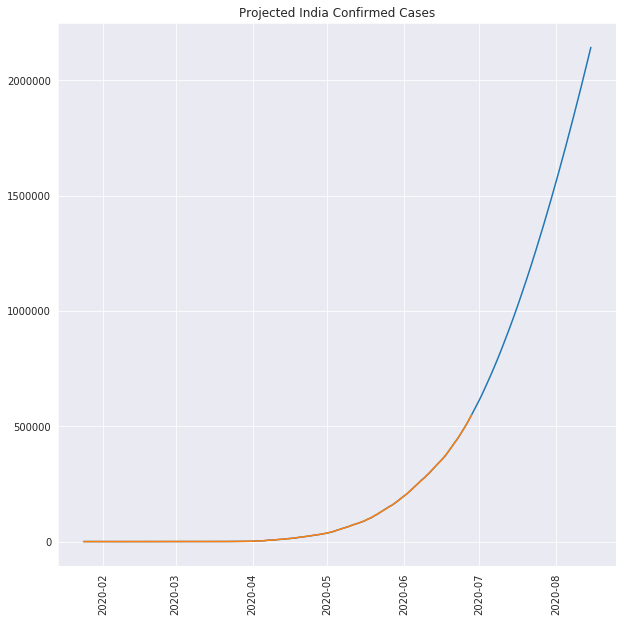

In [181]:
actual = df_trans_confirmed_ind.loc['2020-01-24':, :]
plt.plot(ser2)
plt.plot(actual)
plt.xticks(rotation=90)
plt.title('Projected India Confirmed Cases')
plt.show()

### Converting DataFrame to actual time series data, where each day has number of deaths i.e deaths value is not cumulated.

In [182]:
df_trans_deaths_us = df_trans_deaths[['US']]

In [183]:
df_trans_deaths_us = df_trans_deaths_us.diff(axis=0).fillna(df_trans_deaths_us)

In [184]:
df_trans_deaths_us.tail()

Country/Region,US
2020-06-24,754.0
2020-06-25,2425.0
2020-06-26,629.0
2020-06-27,500.0
2020-06-28,264.0


In [185]:
df_trans_deaths_us.index

DatetimeIndex(['2020-01-22', '2020-01-23',
               '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27',
               '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2020-06-19', '2020-06-20',
               '2020-06-21', '2020-06-22',
               '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26',
               '2020-06-27', '2020-06-28'],
              dtype='datetime64[ns]', length=159, freq=None)

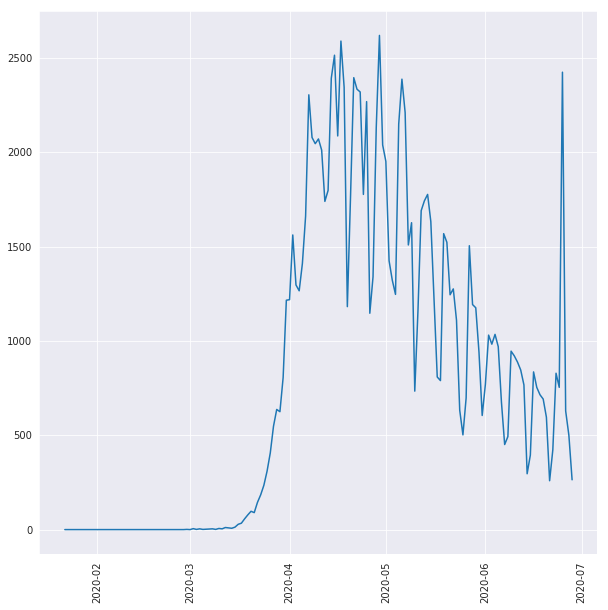

In [186]:
plt.plot(df_trans_deaths_us)
plt.xticks(rotation=90)
plt.show()

In [187]:
df_us1 = df_trans_deaths_us.diff().fillna(df_trans_deaths_us)
df_us1.tail()

Country/Region,US
2020-06-24,-75.0
2020-06-25,1671.0
2020-06-26,-1796.0
2020-06-27,-129.0
2020-06-28,-236.0


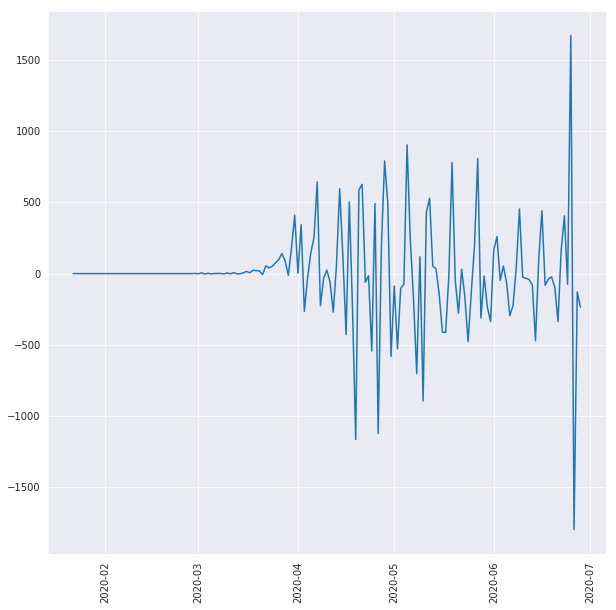

In [188]:
plt.plot(df_us1)
plt.xticks(rotation=90)
plt.show()

In [189]:
df_us1 = df_trans_deaths_us.diff().fillna(df_trans_deaths_us)
df_us1.tail()

Country/Region,US
2020-06-24,-75.0
2020-06-25,1671.0
2020-06-26,-1796.0
2020-06-27,-129.0
2020-06-28,-236.0


In [190]:
df_us2 = df_us1.diff().fillna(df_us1)
df_us2.tail()

Country/Region,US
2020-06-24,-481.0
2020-06-25,1746.0
2020-06-26,-3467.0
2020-06-27,1667.0
2020-06-28,-107.0


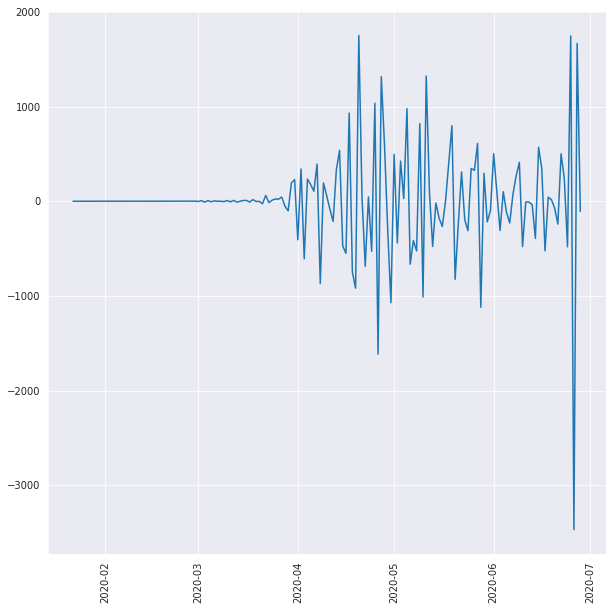

In [191]:
df_us2 = df_us1.diff().fillna(df_us1)
plt.plot(df_us2)
plt.xticks(rotation=90)
plt.show()

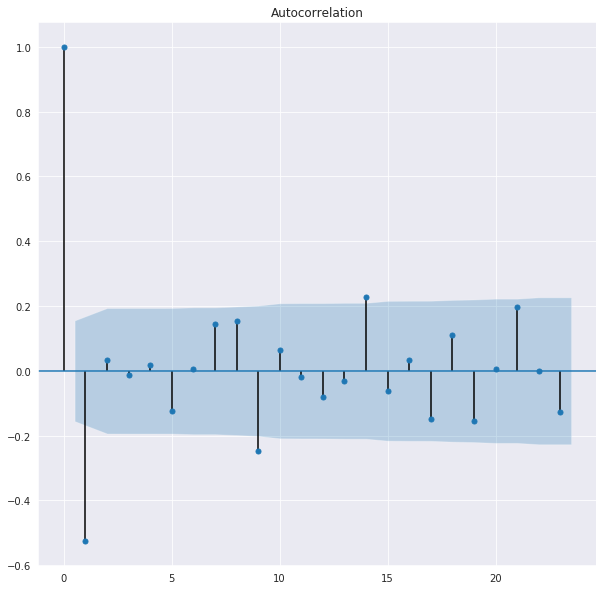

In [192]:
plot_acf(df_us2)
plt.show()

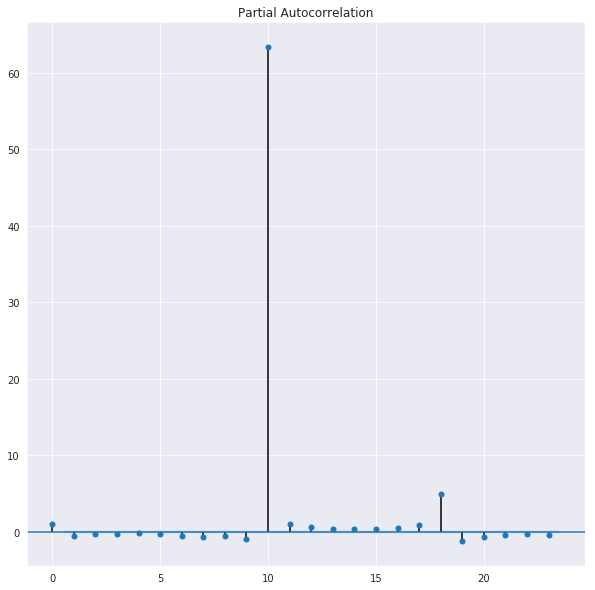

In [193]:
plot_pacf(df_us2)
plt.show()

In [194]:
ARIMA_model = ARIMA(df_trans_deaths_us, order=(9, 1, 6)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [195]:
ARIMA_model.summary()

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/akash/Dev/python/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D.US   No. Observations:                  158
Model:                 ARIMA(9, 1, 6)   Log Likelihood               -1090.432
Method:                       css-mle   S.D. of innovations                nan
Date:                Mon, 29 Jun 2020   AIC                           2214.864
Time:                        21:41:48   BIC                           2266.928
Sample:                    01-23-2020   HQIC                          2236.008
                         - 06-28-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7940     17.961      0.100      0.920     -33.409      36.997
ar.L1.D.US    -0.5427        nan        nan        nan         nan         nan
ar.L2.D.US    -0.4593        nan        nan        nan         nan         nan
ar.L3.D.US    -0.0749        nan        nan        nan         nan         nan
ar.L4.D.US     0.0199      0.091      0.220      0.826      -0.158       0.197
ar.L5.D.US    -0.4290      0.068     -6.326      0.000      -0.562      -0.296
ar.L6.D.US     0.2864      0.064      4.469      0.000       0.161       0.412
ar.L7.D.US     0.5052      0.073      6.937      0.000       0.362       0.648
ar.L8.D.US     0.6711      0.007     99.444      0.000       0.658       0.684
ar.L9.D.US     0.2469        nan        nan        nan         nan         nan
ma.L1.D.US    -0.1473        nan        nan        nan         nan         nan
ma.L2.D.US     0.0555      0.116      0.480      0.631      -0.171       0.282
ma.L3.D.US    -0.3061      0.122     -2.510      0.012      -0.545      -0.067
ma.L4.D.US    -0.0043      0.040     -0.108      0.914      -0.082       0.074
ma.L5.D.US     0.5358      0.117      4.564      0.000       0.306       0.766
ma.L6.D.US    -0.3292      0.070     -4.701      0.000      -0.466      -0.192
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0652           -0.0000j            1.0652           -0.0000
AR.2            0.6292           -0.7786j            1.0010           -0.1418
AR.3            0.6292           +0.7786j            1.0010            0.1418
AR.4           -0.2620           -1.0115j            1.0449           -0.2903
AR.5           -0.2620           +1.0115j            1.0449            0.2903
AR.6           -0.6416           -1.0508j            1.2312           -0.3372
AR.7           -0.6416           +1.0508j            1.2312            0.3372
AR.8           -1.0492           -0.0000j            1.0492           -0.5000
AR.9           -2.1850           -0.0000j            2.1850           -0.5000
MA.1           -1.1299           -0.0000j            1.1299           -0.5000
MA.2           -0.3770           -0.9286j            1.0022           -0.3114
MA.3           -0.3770           +0.9286j            1.0022            0.3114
MA.4            0.9843           -0.8751j            1.3170           -0.1157
MA.5            0.9843           +0.8751j            1.3170            0.1157
MA.6            1.5429           -0.0000j            1.5429           -0.0000
-----------------------------------------------------------------------------
"""

In [196]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-06-25', typ='levels')

In [197]:
arma_predict

2020-06-05    1110.858768
2020-06-06     922.351731
2020-06-07     457.686847
2020-06-08     455.498848
2020-06-09     753.074576
2020-06-10     915.256478
2020-06-11     798.995358
2020-06-12     894.067564
2020-06-13     665.318442
2020-06-14     368.815769
2020-06-15     500.301475
2020-06-16     800.413620
2020-06-17     852.696299
2020-06-18     798.571910
2020-06-19     799.942575
2020-06-20     494.331212
2020-06-21     256.984547
2020-06-22     337.561942
2020-06-23     608.507912
2020-06-24     775.773183
2020-06-25     737.334183
Freq: D, dtype: float64

### Mean Absolute Error for Forecast Evaluation

In [198]:
arma_predict2 = ARIMA_model.predict('2020-01-23', '2020-06-25', typ='levels')
ser2 = arma_predict2

In [199]:
actual = df_trans_deaths_us.loc['2020-01-24':, :]

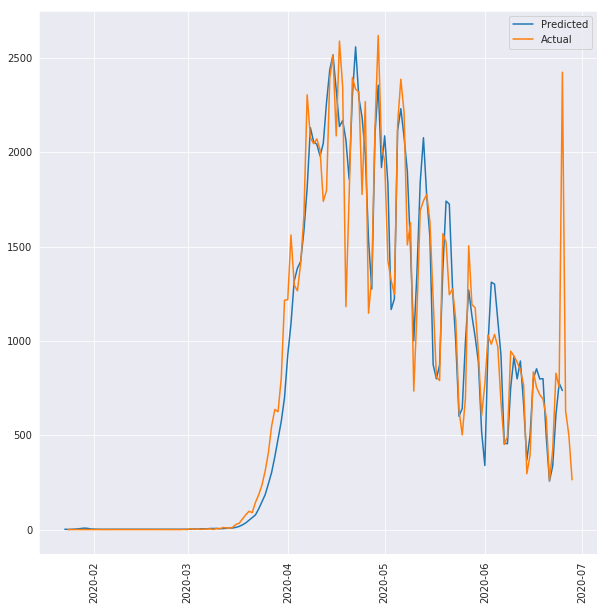

In [200]:
plt.plot(ser2, label='Predicted')
plt.plot(actual, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [201]:
df_new = pd.DataFrame(actual)

In [202]:
df_new['predicted'] = ser2

In [203]:
df_new = df_new.rename(columns={"US":"actual"})

In [204]:
df_new.loc[:, 'error'] = np.absolute(df_new.predicted - df_new.actual)

In [205]:
df_new.tail()

Country/Region,actual,predicted,error
2020-06-24,754.0,775.773183,21.773183
2020-06-25,2425.0,737.334183,1687.665817
2020-06-26,629.0,NaN,NaN
2020-06-27,500.0,NaN,NaN
2020-06-28,264.0,NaN,NaN


In [206]:
df_new.loc[:, 'error_squared'] = np.square(df_new.predicted - df_new.actual)

In [207]:
sum(df_new.error_squared) / len(df_new)

nan

In [208]:
np.sqrt(sum(df_new.error_squared) / len(df_new))

nan

In [209]:
root_mean_square_error = np.sqrt(sum(df_new.error_squared) / len(df_new))

In [210]:
test_results = adfuller(df_us2.US)

In [211]:
test_results[1]

3.616155257996398e-14

### India

### Converting DataFrame to actual time series data, where each day has number of deaths i.e deaths value is not cumulated.

In [212]:
df_trans_deaths_ind = df_trans_deaths[['India']]

In [213]:
df_trans_deaths_ind = df_trans_deaths_ind.diff(axis=0).fillna(df_trans_deaths_ind)

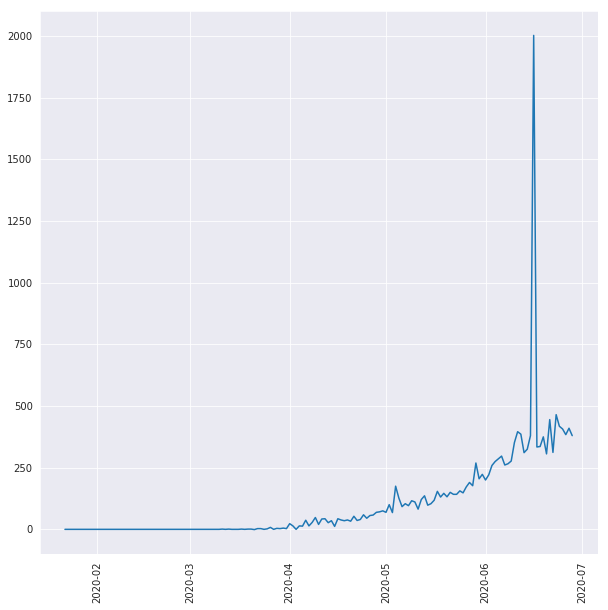

In [214]:
plt.plot(df_trans_deaths_ind)
plt.xticks(rotation=90)
plt.show()

In [215]:
df_ind1 = df_trans_deaths_ind.diff().fillna(df_trans_deaths_ind)
df_ind1.tail()

Country/Region,India
2020-06-24,-47.0
2020-06-25,-11.0
2020-06-26,-23.0
2020-06-27,26.0
2020-06-28,-30.0


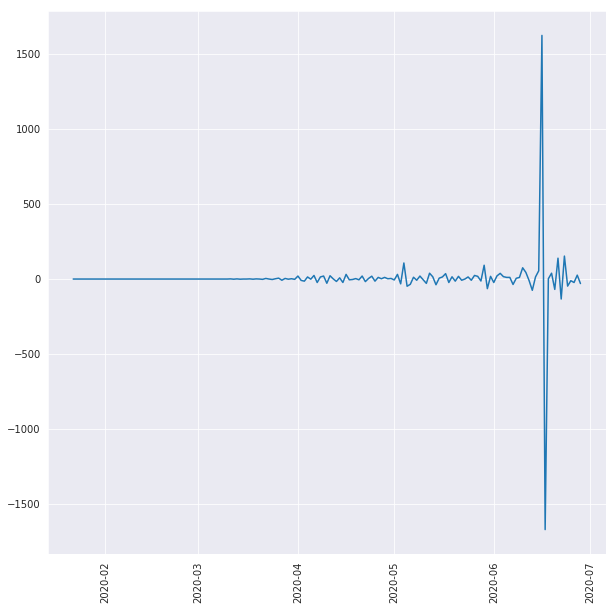

In [216]:
plt.plot(df_ind1)
plt.xticks(rotation=90)
plt.show()

In [217]:
df_ind2 = df_ind1.diff().fillna(df_ind1)
df_ind2.tail()

Country/Region,India
2020-06-24,-200.0
2020-06-25,36.0
2020-06-26,-12.0
2020-06-27,49.0
2020-06-28,-56.0


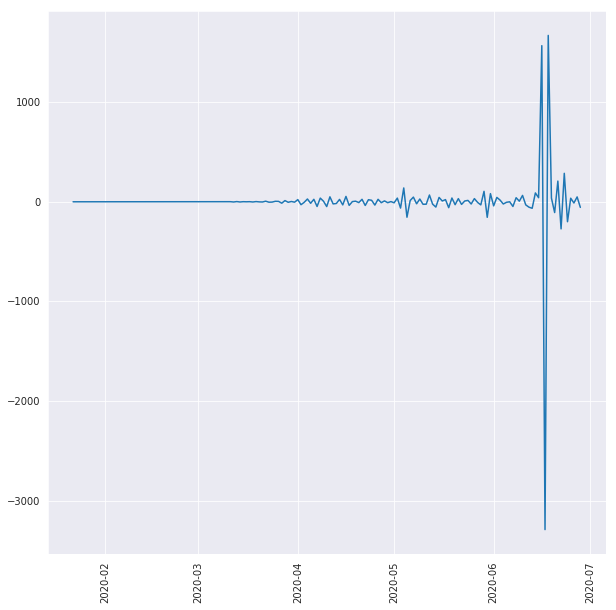

In [218]:
df_ind2 = df_ind1.diff().fillna(df_ind1)
plt.plot(df_ind2)
plt.xticks(rotation=90)
plt.show()

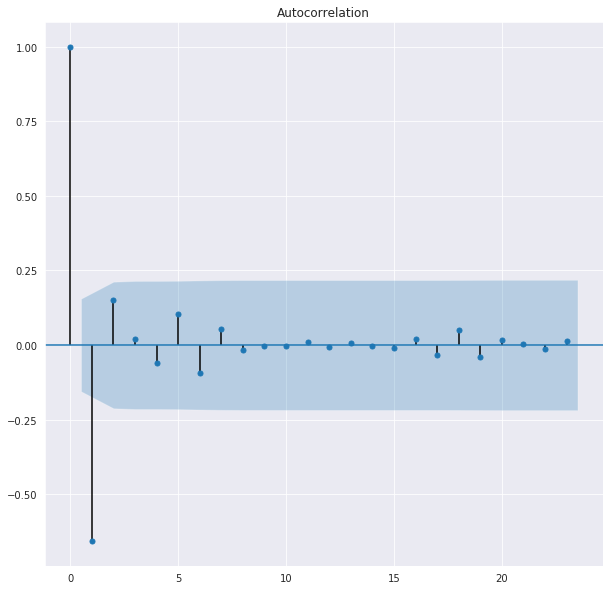

In [219]:
plot_acf(df_ind2)
plt.show()

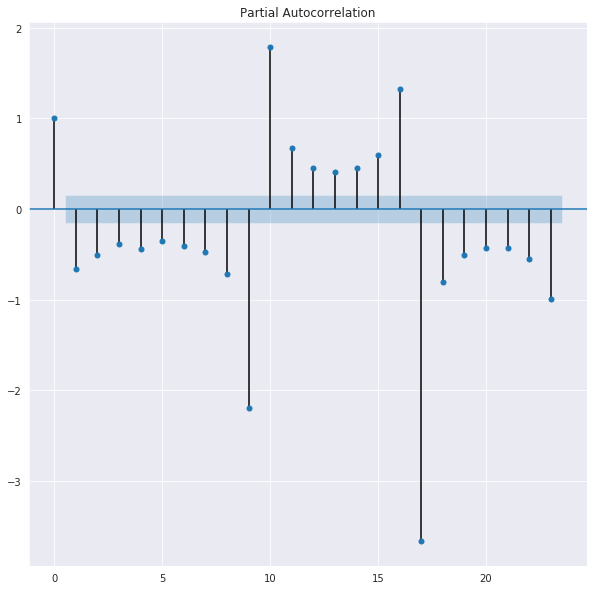

In [220]:
plot_pacf(df_ind2)
plt.show()

In [221]:
list_tup = get_list_of_arma_model_parameters(df_trans_deaths_ind, 2)
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)
ARIMA_model = ARIMA(df_trans_deaths_ind, order=(ar, 2, ma)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred 

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are n

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are 

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are n

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to co

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are no

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [222]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.India   No. Observations:                  157
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -1000.759
Method:                       css-mle   S.D. of innovations            130.834
Date:                Mon, 29 Jun 2020   AIC                           2009.518
Time:                        21:43:03   BIC                           2021.743
Sample:                    01-24-2020   HQIC                          2014.483
                         - 06-28-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0767      0.015      4.963      0.000       0.046       0.107
ma.L1.D2.India    -2.0377      0.069    -29.467      0.000      -2.173      -1.902
ma.L2.D2.India     1.0377      0.070     14.826      0.000       0.901       1.175
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            0.9636           +0.0000j            0.9636            0.0000
MA.2            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [238]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-07-15', typ='levels')

In [239]:
arma_predict

2020-06-05    258.297026
2020-06-06    266.402131
2020-06-07    274.731535
2020-06-08    281.023350
2020-06-09    287.326015
2020-06-10    293.924805
2020-06-11    303.849601
2020-06-12    315.484600
2020-06-13    326.199606
2020-06-14    332.965331
2020-06-15    340.144137
2020-06-16    349.644696
2020-06-17    434.888602
2020-06-18    438.602725
2020-06-19    442.285249
2020-06-20    447.661202
2020-06-21    449.637714
2020-06-22    458.008818
2020-06-23    459.910272
2020-06-24    468.830408
2020-06-25    475.249964
2020-06-26    480.930965
2020-06-27    485.353112
2020-06-28    490.815807
2020-06-29    497.693754
2020-06-30    500.465793
2020-07-01    503.314568
2020-07-02    506.240080
2020-07-03    509.242328
2020-07-04    512.321314
2020-07-05    515.477035
2020-07-06    518.709494
2020-07-07    522.018689
2020-07-08    525.404620
2020-07-09    528.867289
2020-07-10    532.406693
2020-07-11    536.022835
2020-07-12    539.715713
2020-07-13    543.485328
2020-07-14    547.331679


### Mean Absolute Error for Forecast Evaluation

In [225]:
arma_predict2 = ARIMA_model.predict('2020-01-24', '2020-06-28', typ='levels')
ser2 = arma_predict2

In [226]:
actual = df_trans_deaths_ind.loc['2020-01-24':, :]

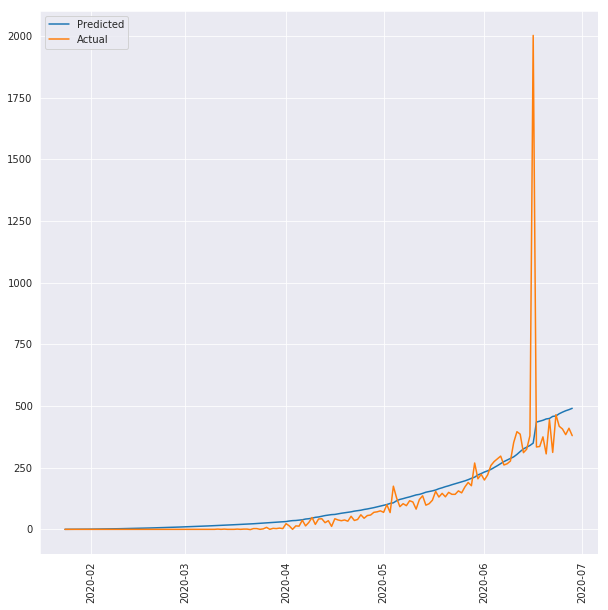

In [227]:
plt.plot(ser2, label='Predicted')
plt.plot(actual, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [228]:
df_new = pd.DataFrame(actual)

In [229]:
df_new['predicted'] = ser2

In [230]:
df_new = df_new.rename(columns={"India":"actual"})

In [231]:
df_new.loc[:, 'error'] = np.absolute(df_new.predicted - df_new.actual)

In [232]:
df_new.tail()

Country/Region,actual,predicted,error
2020-06-24,418.0,468.830408,50.830408
2020-06-25,407.0,475.249964,68.249964
2020-06-26,384.0,480.930965,96.930965
2020-06-27,410.0,485.353112,75.353112
2020-06-28,380.0,490.815807,110.815807


In [233]:
df_new.loc[:, 'error_squared'] = np.square(df_new.predicted - df_new.actual)

In [234]:
sum(df_new.error_squared) / len(df_new)

18634.95478075314

In [235]:
np.sqrt(sum(df_new.error_squared) / len(df_new))

136.50990726226848

In [236]:
root_mean_square_error = np.sqrt(sum(df_new.error_squared) / len(df_new))

In [237]:
root_mean_square_error

136.50990726226848